# COMP90051 Workshop 2
## Part A: Linear regression

***

Our aim for this part of the workshop is to fit a linear model from scratch—relying only on the `numpy` library. We'll experiment with two implementations: one based on iterative updates (coordinate descent) and another based on linear algebra. Finally, to check the correctness of our implementation, we'll compare its output to the output of `sklearn`.

Firstly we will import the relevant libraries (`numpy`, `matplotlib`, etc.).

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import io

To check what a command does simply type `object?`. For example:

In [3]:
np.arange?

### 1. Review
In lectures, we saw that a linear model can be expressed as:
$$y = w_0 + \sum_{j = 1}^{m} w_j x_j = \mathbf{w} \cdot \mathbf{x} $$
where 

* $y$ is the *target variable*;
* $\mathbf{x} = [x_1, \ldots, x_m]$ is a vector of *features* (we define $x_0 = 1$); and
* $\mathbf{w} = [w_0, \ldots, w_m]$ are the *weights*.

To fit the model, we *minimise* the empirical risk with respect to $\vec{w}$. In this simplest case (square loss), this amounts to minimising the sum of squared residuals:

$$SSR(\mathbf{w}) = \sum_{i=1}^{n}(y_i - \mathbf{w} \cdot \mathbf{x}_i)^2$$

**Note:** For simplicity, we'll consider the case $m = 1$ (i.e. only one feature excluding the intercept).

### 2. Data set
We'll be working with some data from the Olympics—the gold medal race times for marathon winners from 1896 to 2012. The code block below reads the data into a numpy array of floats, and prints the result.

In [58]:
# CSV file with variables YEAR,TIME
csv = """1896,4.47083333333333
1900,4.46472925981123
1904,5.22208333333333
1908,4.1546786744085
1912,3.90331674958541
1920,3.5695126705653
1924,3.8245447722874
1928,3.62483706600308
1932,3.59284275388079
1936,3.53880791562981
1948,3.6701030927835
1952,3.39029110874116
1956,3.43642611683849
1960,3.2058300746534
1964,3.13275664573212
1968,3.32819844373346
1972,3.13583757949204
1976,3.07895880238575
1980,3.10581822490816
1984,3.06552909112454
1988,3.09357348817
1992,3.16111703598373
1996,3.14255243512264
2000,3.08527866650867
2004,3.1026582928467
2008,2.99877552632618
2012,3.03392977050993"""

# Read into a numpy array (as floats)
olympics = np.genfromtxt(io.BytesIO(csv.encode()), delimiter=",")
print(olympics)

[[1896.            4.47083333]
 [1900.            4.46472926]
 [1904.            5.22208333]
 [1908.            4.15467867]
 [1912.            3.90331675]
 [1920.            3.56951267]
 [1924.            3.82454477]
 [1928.            3.62483707]
 [1932.            3.59284275]
 [1936.            3.53880792]
 [1948.            3.67010309]
 [1952.            3.39029111]
 [1956.            3.43642612]
 [1960.            3.20583007]
 [1964.            3.13275665]
 [1968.            3.32819844]
 [1972.            3.13583758]
 [1976.            3.0789588 ]
 [1980.            3.10581822]
 [1984.            3.06552909]
 [1988.            3.09357349]
 [1992.            3.16111704]
 [1996.            3.14255244]
 [2000.            3.08527867]
 [2004.            3.10265829]
 [2008.            2.99877553]
 [2012.            3.03392977]]


We'll take the race time as the *target variable* $y$ and the year of the race as the only non-trivial *feature* $x = x_1$.

In [59]:
x = olympics[:, 0:1]
y = olympics[:, 1:2]

Plotting $y$ vs $x$, we see that a linear model could be a decent fit for this data.

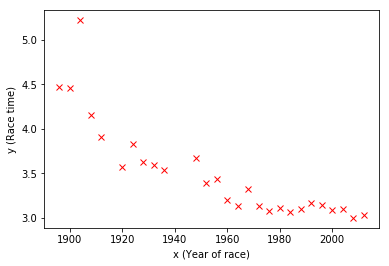

In [60]:
plt.plot(x, y, 'rx')
plt.ylabel("y (Race time)")
plt.xlabel("x (Year of race)")
plt.show()

### 3. Iterative solution (coordinate descent)

Expanding out the sum of square residuals for this simple case (where $\mathbf{w}=[w_0, w_1]$) we have:
$$SSR(w_0, w_1) = \sum_{i=1}^{n}(y_i - w_0 - w_1 x_i)^2$$
Let's start with an initial guess for the slope $w_1$ (which is clearly negative from the plot).

In [70]:
w1 = -0.4

Then using the maximum likelihood update, we get the following estimate for the intercept $w_0$:
$$w_0 = \frac{\sum_{i=1}^{n}(y_i-w_1 x_i)}{n}$$

In [71]:
def update_w0(x, y, w1):
    return np.sum(y - w1 * x) / len(x)

w0 = update_w0(x, y, w1)
print(w0)

786.0197711453593


Similarly, we can update $w_1$ based on this new estimate of $w_0$:
$$w_1 = \frac{\sum_{i=1}^{n} (y_i - w_0) \times x_i}{\sum_{i=1}^{n} x_i^2}$$

In [72]:
def update_w1(x, y, w0):
    return np.sum((y - w0)*x) / np.sum(pow(x, 2))

w1 = update_w1(x, y, w0)
print(w1)

-0.3998724072997095


Let's examine the quality of fit for these values for the weights $w_0$ and $w_1$. We create a vector of "test" values `x_test` and a function to compute the predictions according to the model.

In [73]:
x_test = np.arange(1890, 2020)[:, None]

def predict(x_test, w0, w1): 
    return w0 + w1 * x_test

Now plot the test predictions with a blue line on the same plot as the data.

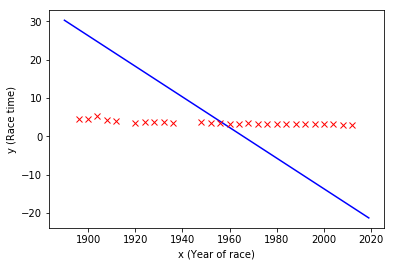

In [74]:
def plot_fit(x_test, y_test, x, y): 
    plt.plot(x_test, y_test, 'b-')
    plt.plot(x, y, 'rx')
    plt.ylabel("y (Race time)")
    plt.xlabel("x (Year of race)")
    plt.show()

plot_fit(x_test, predict(x_test, w0, w1), x, y)

We'll compute the sum of square residuals $SSR(w_0,w_1)$ on the training set to measure the goodness of fit.

In [75]:
def compute_SSR(x, y, w0, w1): 
    return y - (w0+w1*x)

print(compute_SSR(x, y, w0, w1))

[[-23.39085357]
 [-21.79746802]
 [-19.44062431]
 [-18.90853934]
 [-17.56041164]
 [-14.69523646]
 [-12.84071473]
 [-11.44093281]
 [ -9.87343749]
 [ -8.3279827 ]
 [ -3.39821863]
 [ -2.07854099]
 [ -0.43291635]
 [  0.93597724]
 [  2.46239344]
 [  4.25732486]
 [  5.66445363]
 [  7.20706448]
 [  8.83341353]
 [ 10.39261403]
 [ 12.02014805]
 [ 13.68718123]
 [ 15.26810626]
 [ 16.81032212]
 [ 18.42719138]
 [ 19.92279824]
 [ 21.55744211]]


It's obvious from the plot that the fit isn't very good. 
We must repeat the alternating parameter updates many times before the algorithm converges to the optimal weights.

In [82]:
for i in np.arange(10000):
    w1 = update_w1(x, y, w0) 
    w0 = update_w0(x, y, w1) 
#     if i % 50 == 0:
    print("Iteration #{}: SSR = {}".format(i, compute_SSR(x, y, w0, w1)))
print("Final estimates: w0 = {}; w1 = {}".format(w0, w1))

Iteration #0: SSR = [[ 0.18571589]
 [ 0.23161268]
 [ 1.04096761]
 [ 0.02556381]
 [-0.17379725]
 [-0.40359961]
 [-0.09656665]
 [-0.2442735 ]
 [-0.22426695]
 [-0.22630093]
 [ 0.06099683]
 [-0.16681429]
 [-0.06867843]
 [-0.24727361]
 [-0.26834618]
 [-0.02090352]
 [-0.16126352]
 [-0.16614144]
 [-0.08728116]
 [-0.07556943]
 [ 0.00447583]
 [ 0.12402023]
 [ 0.15745649]
 [ 0.15218358]
 [ 0.22156407]
 [ 0.16968216]
 [ 0.25683727]]
Iteration #1: SSR = [[ 0.18571628]
 [ 0.23161304]
 [ 1.04096795]
 [ 0.02556412]
 [-0.17379697]
 [-0.40359938]
 [-0.09656644]
 [-0.24427331]
 [-0.22426679]
 [-0.2263008 ]
 [ 0.06099688]
 [-0.16681427]
 [-0.06867842]
 [-0.24727363]
 [-0.26834623]
 [-0.02090359]
 [-0.16126362]
 [-0.16614157]
 [-0.08728131]
 [-0.07556961]
 [ 0.00447562]
 [ 0.12402   ]
 [ 0.15745624]
 [ 0.1521833 ]
 [ 0.22156376]
 [ 0.16968183]
 [ 0.25683691]]
Iteration #2: SSR = [[ 0.18571667]
 [ 0.2316134 ]
 [ 1.04096829]
 [ 0.02556444]
 [-0.17379668]
 [-0.40359914]
 [-0.09656623]
 [-0.24427313]
 [-0.224

 [ 0.25673298]]
Iteration #306: SSR = [[ 0.18582913]
 [ 0.2317184 ]
 [ 1.04106582]
 [ 0.02565451]
 [-0.17371407]
 [-0.40353145]
 [-0.096506  ]
 [-0.24422036]
 [-0.22422132]
 [-0.22626281]
 [ 0.06101241]
 [-0.16680623]
 [-0.06867787]
 [-0.24728056]
 [-0.26836064]
 [-0.0209255 ]
 [-0.16129301]
 [-0.16617844]
 [-0.08732567]
 [-0.07562146]
 [ 0.00441629]
 [ 0.12395318]
 [ 0.15738193]
 [ 0.15210151]
 [ 0.22147448]
 [ 0.16958507]
 [ 0.25673266]]
Iteration #307: SSR = [[ 0.18582948]
 [ 0.23171873]
 [ 1.04106613]
 [ 0.02565479]
 [-0.17371381]
 [-0.40353124]
 [-0.09650581]
 [-0.24422019]
 [-0.22422118]
 [-0.22626269]
 [ 0.06101246]
 [-0.1668062 ]
 [-0.06867787]
 [-0.24728058]
 [-0.26836069]
 [-0.02092557]
 [-0.16129311]
 [-0.16617856]
 [-0.08732581]
 [-0.07562162]
 [ 0.0044161 ]
 [ 0.12395297]
 [ 0.1573817 ]
 [ 0.15210125]
 [ 0.22147421]
 [ 0.16958476]
 [ 0.25673233]]
Iteration #308: SSR = [[ 0.18582983]
 [ 0.23171906]
 [ 1.04106643]
 [ 0.02565507]
 [-0.17371355]
 [-0.40353102]
 [-0.09650562]
 

 [ 0.25664635]]
Iteration #585: SSR = [[ 0.18592287]
 [ 0.23180593]
 [ 1.04114713]
 [ 0.0257296 ]
 [-0.1736452 ]
 [-0.40347502]
 [-0.09645579]
 [-0.24417636]
 [-0.22418355]
 [-0.22623126]
 [ 0.06102531]
 [-0.16679955]
 [-0.06867741]
 [-0.24728632]
 [-0.26837262]
 [-0.02094369]
 [-0.16131743]
 [-0.16620908]
 [-0.08736253]
 [-0.07566453]
 [ 0.004367  ]
 [ 0.12389767]
 [ 0.1573202 ]
 [ 0.15203356]
 [ 0.22140032]
 [ 0.16950468]
 [ 0.25664605]]
Iteration #586: SSR = [[ 0.18592319]
 [ 0.23180623]
 [ 1.04114741]
 [ 0.02572986]
 [-0.17364496]
 [-0.40347482]
 [-0.09645561]
 [-0.24417621]
 [-0.22418342]
 [-0.22623115]
 [ 0.06102535]
 [-0.16679952]
 [-0.06867741]
 [-0.24728634]
 [-0.26837266]
 [-0.02094376]
 [-0.16131751]
 [-0.16620918]
 [-0.08736265]
 [-0.07566468]
 [ 0.00436683]
 [ 0.12389748]
 [ 0.15731999]
 [ 0.15203333]
 [ 0.22140006]
 [ 0.1695044 ]
 [ 0.25664576]]
Iteration #587: SSR = [[ 0.18592351]
 [ 0.23180653]
 [ 1.04114769]
 [ 0.02573011]
 [-0.17364473]
 [-0.40347463]
 [-0.09645544]
 

 [ 0.25657412]]
Iteration #839: SSR = [[ 0.18600103]
 [ 0.2318789 ]
 [ 1.04121492]
 [ 0.0257922 ]
 [-0.17358778]
 [-0.40342797]
 [-0.09641392]
 [-0.24413968]
 [-0.22415205]
 [-0.22620495]
 [ 0.06103606]
 [-0.16679398]
 [-0.06867702]
 [-0.24729112]
 [-0.26838261]
 [-0.02095887]
 [-0.16133779]
 [-0.16623462]
 [-0.08739325]
 [-0.07570044]
 [ 0.0043259 ]
 [ 0.12385139]
 [ 0.15726873]
 [ 0.15197691]
 [ 0.22133848]
 [ 0.16943766]
 [ 0.25657385]]
Iteration #840: SSR = [[ 0.18600133]
 [ 0.23187918]
 [ 1.04121518]
 [ 0.02579244]
 [-0.17358756]
 [-0.40342779]
 [-0.09641376]
 [-0.24413955]
 [-0.22415193]
 [-0.22620485]
 [ 0.0610361 ]
 [-0.16679396]
 [-0.06867702]
 [-0.24729114]
 [-0.26838265]
 [-0.02095892]
 [-0.16133786]
 [-0.16623471]
 [-0.08739337]
 [-0.07570058]
 [ 0.00432574]
 [ 0.12385122]
 [ 0.15726854]
 [ 0.1519767 ]
 [ 0.22133825]
 [ 0.16943741]
 [ 0.25657357]]
Iteration #841: SSR = [[ 0.18600162]
 [ 0.23187945]
 [ 1.04121543]
 [ 0.02579268]
 [-0.17358734]
 [-0.40342761]
 [-0.09641361]
 

 [ 0.25649798]]
Iteration #1132: SSR = [[ 0.18608343]
 [ 0.23195583]
 [ 1.04128638]
 [ 0.0258582 ]
 [-0.17352725]
 [-0.40337837]
 [-0.09636979]
 [-0.24410102]
 [-0.22411885]
 [-0.22617721]
 [ 0.0610474 ]
 [-0.16678811]
 [-0.06867662]
 [-0.24729618]
 [-0.26839313]
 [-0.02097486]
 [-0.16135924]
 [-0.16626154]
 [-0.08742564]
 [-0.0757383 ]
 [ 0.00428258]
 [ 0.1238026 ]
 [ 0.15721448]
 [ 0.15191719]
 [ 0.22127329]
 [ 0.16936701]
 [ 0.25649773]]
Iteration #1133: SSR = [[ 0.18608369]
 [ 0.23195608]
 [ 1.04128661]
 [ 0.02585842]
 [-0.17352705]
 [-0.40337821]
 [-0.09636965]
 [-0.24410089]
 [-0.22411874]
 [-0.22617712]
 [ 0.06104744]
 [-0.16678809]
 [-0.06867662]
 [-0.2472962 ]
 [-0.26839317]
 [-0.02097491]
 [-0.16135931]
 [-0.16626163]
 [-0.08742575]
 [-0.07573842]
 [ 0.00428244]
 [ 0.12380244]
 [ 0.1572143 ]
 [ 0.151917  ]
 [ 0.22127308]
 [ 0.16936678]
 [ 0.25649748]]
Iteration #1134: SSR = [[ 0.18608396]
 [ 0.23195633]
 [ 1.04128685]
 [ 0.02585863]
 [-0.17352685]
 [-0.40337805]
 [-0.0963695 

Iteration #1439: SSR = [[ 0.18616163]
 [ 0.23202884]
 [ 1.04135421]
 [ 0.02592084]
 [-0.17346979]
 [-0.40333129]
 [-0.0963279 ]
 [-0.24406432]
 [-0.22408734]
 [-0.22615089]
 [ 0.06105816]
 [-0.16678253]
 [-0.06867624]
 [-0.24730099]
 [-0.26840313]
 [-0.02099004]
 [-0.16137961]
 [-0.1662871 ]
 [-0.08745639]
 [-0.07577423]
 [ 0.00424146]
 [ 0.1237563 ]
 [ 0.15716299]
 [ 0.15186051]
 [ 0.22121142]
 [ 0.16929995]
 [ 0.25642548]]
Iteration #1440: SSR = [[ 0.18616187]
 [ 0.23202907]
 [ 1.04135442]
 [ 0.02592103]
 [-0.17346962]
 [-0.40333115]
 [-0.09632777]
 [-0.2440642 ]
 [-0.22408724]
 [-0.22615081]
 [ 0.06105819]
 [-0.16678252]
 [-0.06867623]
 [-0.247301  ]
 [-0.26840316]
 [-0.02099008]
 [-0.16137967]
 [-0.16628718]
 [-0.08745648]
 [-0.07577434]
 [ 0.00424133]
 [ 0.12375615]
 [ 0.15716283]
 [ 0.15186033]
 [ 0.22121123]
 [ 0.16929974]
 [ 0.25642526]]
Iteration #1441: SSR = [[ 0.18616211]
 [ 0.2320293 ]
 [ 1.04135463]
 [ 0.02592123]
 [-0.17346944]
 [-0.403331  ]
 [-0.09632764]
 [-0.24406409]

Iteration #1597: SSR = [[ 0.18619889]
 [ 0.23206364]
 [ 1.04138653]
 [ 0.02595069]
 [-0.17344242]
 [-0.40330886]
 [-0.09630794]
 [-0.24404683]
 [-0.22407232]
 [-0.22613834]
 [ 0.06106329]
 [-0.16677988]
 [-0.06867605]
 [-0.24730328]
 [-0.26840789]
 [-0.02099727]
 [-0.16138932]
 [-0.16629928]
 [-0.08747104]
 [-0.07579135]
 [ 0.00422186]
 [ 0.12373423]
 [ 0.15713845]
 [ 0.1518335 ]
 [ 0.22118194]
 [ 0.16926799]
 [ 0.25639105]]
Iteration #1598: SSR = [[ 0.18619912]
 [ 0.23206385]
 [ 1.04138673]
 [ 0.02595087]
 [-0.17344225]
 [-0.40330872]
 [-0.09630782]
 [-0.24404672]
 [-0.22407223]
 [-0.22613827]
 [ 0.06106332]
 [-0.16677986]
 [-0.06867605]
 [-0.24730329]
 [-0.26840792]
 [-0.02099732]
 [-0.16138938]
 [-0.16629935]
 [-0.08747113]
 [-0.07579146]
 [ 0.00422174]
 [ 0.12373409]
 [ 0.1571383 ]
 [ 0.15183333]
 [ 0.22118176]
 [ 0.16926779]
 [ 0.25639084]]
Iteration #1599: SSR = [[ 0.18619935]
 [ 0.23206407]
 [ 1.04138693]
 [ 0.02595106]
 [-0.17344208]
 [-0.40330858]
 [-0.09630769]
 [-0.24404661]

 [ 0.2563614 ]]
Iteration #1741: SSR = [[ 0.18623121]
 [ 0.23209381]
 [ 1.04141456]
 [ 0.02597657]
 [-0.17341868]
 [-0.40328941]
 [-0.09629063]
 [-0.24403166]
 [-0.2240593 ]
 [-0.22612747]
 [ 0.06106773]
 [-0.16677758]
 [-0.06867589]
 [-0.24730526]
 [-0.26841202]
 [-0.02100354]
 [-0.16139773]
 [-0.16630984]
 [-0.08748374]
 [-0.0758062 ]
 [ 0.00420487]
 [ 0.1237151 ]
 [ 0.15711717]
 [ 0.15181007]
 [ 0.22115638]
 [ 0.16924028]
 [ 0.2563612 ]]
Iteration #1742: SSR = [[ 0.18623143]
 [ 0.23209401]
 [ 1.04141475]
 [ 0.02597675]
 [-0.17341852]
 [-0.40328928]
 [-0.09629052]
 [-0.24403156]
 [-0.22405921]
 [-0.22612739]
 [ 0.06106776]
 [-0.16677756]
 [-0.06867589]
 [-0.24730527]
 [-0.26841204]
 [-0.02100359]
 [-0.16139779]
 [-0.16630991]
 [-0.08748383]
 [-0.0758063 ]
 [ 0.00420476]
 [ 0.12371497]
 [ 0.15711702]
 [ 0.15180992]
 [ 0.2211562 ]
 [ 0.1692401 ]
 [ 0.256361  ]]
Iteration #1743: SSR = [[ 0.18623165]
 [ 0.23209422]
 [ 1.04141494]
 [ 0.02597692]
 [-0.17341836]
 [-0.40328915]
 [-0.0962904 

 [ 0.25633196]]
Iteration #1890: SSR = [[ 0.18626307]
 [ 0.23212355]
 [ 1.04144219]
 [ 0.02600209]
 [-0.17339527]
 [-0.40327023]
 [-0.09627357]
 [-0.24401671]
 [-0.22404647]
 [-0.22611674]
 [ 0.06107212]
 [-0.16677531]
 [-0.06867574]
 [-0.24730722]
 [-0.26841609]
 [-0.02100973]
 [-0.16140603]
 [-0.16632025]
 [-0.08749626]
 [-0.07582084]
 [ 0.00418812]
 [ 0.12369623]
 [ 0.15709619]
 [ 0.15178698]
 [ 0.22113117]
 [ 0.16921296]
 [ 0.25633177]]
Iteration #1891: SSR = [[ 0.18626328]
 [ 0.23212375]
 [ 1.04144237]
 [ 0.02600226]
 [-0.17339512]
 [-0.40327011]
 [-0.09627346]
 [-0.24401662]
 [-0.22404638]
 [-0.22611667]
 [ 0.06107215]
 [-0.16677529]
 [-0.06867574]
 [-0.24730723]
 [-0.26841611]
 [-0.02100977]
 [-0.16140608]
 [-0.16632031]
 [-0.08749635]
 [-0.07582093]
 [ 0.00418801]
 [ 0.12369611]
 [ 0.15709605]
 [ 0.15178683]
 [ 0.221131  ]
 [ 0.16921279]
 [ 0.25633158]]
Iteration #1892: SSR = [[ 0.18626348]
 [ 0.23212394]
 [ 1.04144255]
 [ 0.02600242]
 [-0.17339497]
 [-0.40326998]
 [-0.09627334

Iteration #2030: SSR = [[ 0.18629161]
 [ 0.2321502 ]
 [ 1.04146694]
 [ 0.02602495]
 [-0.17337431]
 [-0.40325305]
 [-0.09625828]
 [-0.24400332]
 [-0.22403496]
 [-0.22610714]
 [ 0.06107604]
 [-0.16677327]
 [-0.0686756 ]
 [-0.24730897]
 [-0.26841973]
 [-0.02101527]
 [-0.16141346]
 [-0.16632957]
 [-0.08750748]
 [-0.07583395]
 [ 0.00417311]
 [ 0.12367933]
 [ 0.1570774 ]
 [ 0.1517663 ]
 [ 0.22110859]
 [ 0.16918849]
 [ 0.2563054 ]]
Iteration #2031: SSR = [[ 0.18629181]
 [ 0.23215039]
 [ 1.04146712]
 [ 0.02602511]
 [-0.17337416]
 [-0.40325293]
 [-0.09625817]
 [-0.24400323]
 [-0.22403488]
 [-0.22610707]
 [ 0.06107607]
 [-0.16677326]
 [-0.0686756 ]
 [-0.24730898]
 [-0.26841976]
 [-0.02101531]
 [-0.16141352]
 [-0.16632964]
 [-0.08750756]
 [-0.07583404]
 [ 0.00417301]
 [ 0.12367921]
 [ 0.15707727]
 [ 0.15176615]
 [ 0.22110843]
 [ 0.16918832]
 [ 0.25630522]]
Iteration #2032: SSR = [[ 0.18629201]
 [ 0.23215057]
 [ 1.04146729]
 [ 0.02602527]
 [-0.17337401]
 [-0.40325281]
 [-0.09625807]
 [-0.24400313]

 [ 0.25626584]]
Iteration #2254: SSR = [[ 0.18633462]
 [ 0.23219036]
 [ 1.04150425]
 [ 0.0260594 ]
 [-0.17334271]
 [-0.40322716]
 [-0.09623524]
 [-0.24398313]
 [-0.22401763]
 [-0.22609266]
 [ 0.06108196]
 [-0.16677021]
 [-0.06867539]
 [-0.24731161]
 [-0.26842523]
 [-0.02102362]
 [-0.16142467]
 [-0.16634363]
 [-0.08752439]
 [-0.07585371]
 [ 0.0041505 ]
 [ 0.12365386]
 [ 0.15704907]
 [ 0.15173512]
 [ 0.22107456]
 [ 0.16915161]
 [ 0.25626567]]
Iteration #2255: SSR = [[ 0.18633481]
 [ 0.23219053]
 [ 1.04150441]
 [ 0.02605955]
 [-0.17334257]
 [-0.40322705]
 [-0.09623514]
 [-0.24398305]
 [-0.22401756]
 [-0.22609259]
 [ 0.06108199]
 [-0.16677019]
 [-0.06867538]
 [-0.24731162]
 [-0.26842525]
 [-0.02102365]
 [-0.16142471]
 [-0.16634369]
 [-0.08752447]
 [-0.0758538 ]
 [ 0.0041504 ]
 [ 0.12365375]
 [ 0.15704895]
 [ 0.15173499]
 [ 0.22107441]
 [ 0.16915145]
 [ 0.25626549]]
Iteration #2256: SSR = [[ 0.18633499]
 [ 0.23219071]
 [ 1.04150457]
 [ 0.0260597 ]
 [-0.17334244]
 [-0.40322694]
 [-0.09623504

 [ 0.25624195]]
Iteration #2397: SSR = [[ 0.18636046]
 [ 0.23221449]
 [ 1.04152666]
 [ 0.0260801 ]
 [-0.17332372]
 [-0.4032116 ]
 [-0.0962214 ]
 [-0.24397101]
 [-0.22400722]
 [-0.22608396]
 [ 0.06108552]
 [-0.16676837]
 [-0.06867526]
 [-0.2473132 ]
 [-0.26842853]
 [-0.02102863]
 [-0.1614314 ]
 [-0.16635207]
 [-0.08753455]
 [-0.07586559]
 [ 0.00413691]
 [ 0.12363856]
 [ 0.15703206]
 [ 0.15171639]
 [ 0.22105411]
 [ 0.16912945]
 [ 0.25624179]]
Iteration #2398: SSR = [[ 0.18636064]
 [ 0.23221465]
 [ 1.04152682]
 [ 0.02608024]
 [-0.17332359]
 [-0.4032115 ]
 [-0.09622131]
 [-0.24397092]
 [-0.22400715]
 [-0.2260839 ]
 [ 0.06108554]
 [-0.16676835]
 [-0.06867526]
 [-0.24731321]
 [-0.26842855]
 [-0.02102867]
 [-0.16143144]
 [-0.16635213]
 [-0.08753462]
 [-0.07586567]
 [ 0.00413682]
 [ 0.12363845]
 [ 0.15703194]
 [ 0.15171626]
 [ 0.22105397]
 [ 0.1691293 ]
 [ 0.25624163]]
Iteration #2399: SSR = [[ 0.18636082]
 [ 0.23221482]
 [ 1.04152697]
 [ 0.02608039]
 [-0.17332346]
 [-0.40321139]
 [-0.09622121

 [ 0.25621886]]
Iteration #2542: SSR = [[ 0.18638545]
 [ 0.23223782]
 [ 1.04154834]
 [ 0.02610012]
 [-0.17330536]
 [-0.40319656]
 [-0.09620801]
 [-0.24395928]
 [-0.22399715]
 [-0.22607555]
 [ 0.06108896]
 [-0.16676659]
 [-0.06867514]
 [-0.24731474]
 [-0.26843172]
 [-0.02103348]
 [-0.16143791]
 [-0.16636024]
 [-0.08754438]
 [-0.07587707]
 [ 0.00412377]
 [ 0.12362376]
 [ 0.1570156 ]
 [ 0.15169828]
 [ 0.22103434]
 [ 0.16910802]
 [ 0.2562187 ]]
Iteration #2543: SSR = [[ 0.18638562]
 [ 0.23223798]
 [ 1.04154848]
 [ 0.02610025]
 [-0.17330524]
 [-0.40319646]
 [-0.09620792]
 [-0.2439592 ]
 [-0.22399708]
 [-0.22607549]
 [ 0.06108898]
 [-0.16676657]
 [-0.06867513]
 [-0.24731475]
 [-0.26843174]
 [-0.02103352]
 [-0.16143795]
 [-0.1663603 ]
 [-0.08754444]
 [-0.07587715]
 [ 0.00412368]
 [ 0.12362366]
 [ 0.15701549]
 [ 0.15169815]
 [ 0.22103421]
 [ 0.16910787]
 [ 0.25621855]]
Iteration #2544: SSR = [[ 0.18638579]
 [ 0.23223814]
 [ 1.04154863]
 [ 0.02610039]
 [-0.17330512]
 [-0.40319636]
 [-0.09620783

 [ 0.25619655]]
Iteration #2689: SSR = [[ 0.1864096 ]
 [ 0.23226036]
 [ 1.04156928]
 [ 0.02611946]
 [-0.17328763]
 [-0.40318203]
 [-0.09619508]
 [-0.24394795]
 [-0.22398742]
 [-0.22606742]
 [ 0.06109228]
 [-0.16676487]
 [-0.06867502]
 [-0.24731622]
 [-0.26843481]
 [-0.02103817]
 [-0.16144419]
 [-0.16636813]
 [-0.08755387]
 [-0.07588816]
 [ 0.00411108]
 [ 0.12360946]
 [ 0.1569997 ]
 [ 0.15168078]
 [ 0.22101524]
 [ 0.16908732]
 [ 0.2561964 ]]
Iteration #2690: SSR = [[ 0.18640976]
 [ 0.23226051]
 [ 1.04156942]
 [ 0.02611959]
 [-0.17328751]
 [-0.40318193]
 [-0.096195  ]
 [-0.24394787]
 [-0.22398736]
 [-0.22606737]
 [ 0.0610923 ]
 [-0.16676485]
 [-0.06867502]
 [-0.24731623]
 [-0.26843483]
 [-0.0210382 ]
 [-0.16144423]
 [-0.16636818]
 [-0.08755393]
 [-0.07588823]
 [ 0.00411099]
 [ 0.12360937]
 [ 0.1569996 ]
 [ 0.15168066]
 [ 0.22101512]
 [ 0.16908718]
 [ 0.25619625]]
Iteration #2691: SSR = [[ 0.18640992]
 [ 0.23226066]
 [ 1.04156955]
 [ 0.02611971]
 [-0.17328739]
 [-0.40318183]
 [-0.09619491

 [ 0.25617741]]
Iteration #2821: SSR = [[ 0.1864303 ]
 [ 0.23227969]
 [ 1.04158723]
 [ 0.02613604]
 [-0.17327242]
 [-0.40316956]
 [-0.09618399]
 [-0.24393823]
 [-0.22397908]
 [-0.22606045]
 [ 0.06109513]
 [-0.16676339]
 [-0.06867491]
 [-0.24731749]
 [-0.26843745]
 [-0.02104219]
 [-0.16144959]
 [-0.1663749 ]
 [-0.08756201]
 [-0.07589767]
 [ 0.00410019]
 [ 0.1235972 ]
 [ 0.15698607]
 [ 0.15166577]
 [ 0.22099886]
 [ 0.16906956]
 [ 0.25617727]]
Iteration #2822: SSR = [[ 0.18643045]
 [ 0.23227984]
 [ 1.04158737]
 [ 0.02613617]
 [-0.1732723 ]
 [-0.40316947]
 [-0.09618391]
 [-0.24393816]
 [-0.22397902]
 [-0.2260604 ]
 [ 0.06109515]
 [-0.16676338]
 [-0.06867491]
 [-0.2473175 ]
 [-0.26843747]
 [-0.02104222]
 [-0.16144963]
 [-0.16637495]
 [-0.08756207]
 [-0.07589774]
 [ 0.00410011]
 [ 0.12359711]
 [ 0.15698597]
 [ 0.15166566]
 [ 0.22099874]
 [ 0.16906943]
 [ 0.25617713]]
Iteration #2823: SSR = [[ 0.18643061]
 [ 0.23227998]
 [ 1.0415875 ]
 [ 0.02613629]
 [-0.17327219]
 [-0.40316938]
 [-0.09618383

 [ 0.25615585]]
Iteration #2977: SSR = [[ 0.18645364]
 [ 0.23230148]
 [ 1.04160747]
 [ 0.02615473]
 [-0.17325527]
 [-0.40315551]
 [-0.09617149]
 [-0.24392728]
 [-0.22396968]
 [-0.22605259]
 [ 0.06109834]
 [-0.16676173]
 [-0.0686748 ]
 [-0.24731892]
 [-0.26844043]
 [-0.02104672]
 [-0.16145566]
 [-0.16638252]
 [-0.08757118]
 [-0.0759084 ]
 [ 0.00408792]
 [ 0.12358339]
 [ 0.1569707 ]
 [ 0.15164885]
 [ 0.2209804 ]
 [ 0.16904955]
 [ 0.25615571]]
Iteration #2978: SSR = [[ 0.18645378]
 [ 0.23230162]
 [ 1.0416076 ]
 [ 0.02615485]
 [-0.17325517]
 [-0.40315543]
 [-0.09617142]
 [-0.24392721]
 [-0.22396962]
 [-0.22605255]
 [ 0.06109836]
 [-0.16676172]
 [-0.0686748 ]
 [-0.24731893]
 [-0.26844045]
 [-0.02104675]
 [-0.1614557 ]
 [-0.16638257]
 [-0.08757124]
 [-0.07590846]
 [ 0.00408784]
 [ 0.1235833 ]
 [ 0.15697061]
 [ 0.15164875]
 [ 0.22098028]
 [ 0.16904943]
 [ 0.25615558]]
Iteration #2979: SSR = [[ 0.18645393]
 [ 0.23230175]
 [ 1.04160773]
 [ 0.02615497]
 [-0.17325506]
 [-0.40315534]
 [-0.09617134

 [ 0.25612501]]
Iteration #3215: SSR = [[ 0.186487  ]
 [ 0.23233264]
 [ 1.04163641]
 [ 0.02618146]
 [-0.17323076]
 [-0.40313543]
 [-0.09615362]
 [-0.24391162]
 [-0.22395623]
 [-0.22604136]
 [ 0.06110293]
 [-0.16675935]
 [-0.06867464]
 [-0.24732097]
 [-0.2684447 ]
 [-0.02105319]
 [-0.16146435]
 [-0.16639343]
 [-0.0875843 ]
 [-0.07592373]
 [ 0.00407038]
 [ 0.12356363]
 [ 0.15694873]
 [ 0.15162467]
 [ 0.220954  ]
 [ 0.16902094]
 [ 0.25612489]]
Iteration #3216: SSR = [[ 0.18648714]
 [ 0.23233276]
 [ 1.04163653]
 [ 0.02618157]
 [-0.17323066]
 [-0.40313535]
 [-0.09615355]
 [-0.24391156]
 [-0.22395618]
 [-0.22604132]
 [ 0.06110295]
 [-0.16675934]
 [-0.06867464]
 [-0.24732098]
 [-0.26844471]
 [-0.02105322]
 [-0.16146439]
 [-0.16639347]
 [-0.08758435]
 [-0.07592379]
 [ 0.0040703 ]
 [ 0.12356355]
 [ 0.15694864]
 [ 0.15162457]
 [ 0.22095389]
 [ 0.16902082]
 [ 0.25612476]]
Iteration #3217: SSR = [[ 0.18648727]
 [ 0.23233289]
 [ 1.04163665]
 [ 0.02618168]
 [-0.17323056]
 [-0.40313527]
 [-0.09615348

 [ 0.25610667]]
Iteration #3366: SSR = [[ 0.18650686]
 [ 0.23235117]
 [ 1.04165363]
 [ 0.02619736]
 [-0.17321618]
 [-0.40312348]
 [-0.09614299]
 [-0.24390231]
 [-0.22394823]
 [-0.22603468]
 [ 0.06110566]
 [-0.16675793]
 [-0.06867454]
 [-0.24732219]
 [-0.26844723]
 [-0.02105705]
 [-0.16146952]
 [-0.16639991]
 [-0.0875921 ]
 [-0.07593285]
 [ 0.00405994]
 [ 0.12355187]
 [ 0.15693566]
 [ 0.15161028]
 [ 0.22093829]
 [ 0.16900392]
 [ 0.25610655]]
Iteration #3367: SSR = [[ 0.18650698]
 [ 0.23235129]
 [ 1.04165374]
 [ 0.02619746]
 [-0.17321608]
 [-0.4031234 ]
 [-0.09614292]
 [-0.24390225]
 [-0.22394818]
 [-0.22603464]
 [ 0.06110568]
 [-0.16675793]
 [-0.06867454]
 [-0.2473222 ]
 [-0.26844725]
 [-0.02105707]
 [-0.16146956]
 [-0.16639995]
 [-0.08759215]
 [-0.07593291]
 [ 0.00405987]
 [ 0.1235518 ]
 [ 0.15693558]
 [ 0.15161019]
 [ 0.22093819]
 [ 0.16900381]
 [ 0.25610643]]
Iteration #3368: SSR = [[ 0.18650711]
 [ 0.23235141]
 [ 1.04165385]
 [ 0.02619757]
 [-0.17321599]
 [-0.40312332]
 [-0.09614285

 [ 0.25609023]]
Iteration #3508: SSR = [[ 0.18652464]
 [ 0.23236778]
 [ 1.04166906]
 [ 0.02621161]
 [-0.17320311]
 [-0.40311277]
 [-0.09613346]
 [-0.24389396]
 [-0.22394106]
 [-0.22602869]
 [ 0.06110811]
 [-0.16675667]
 [-0.06867445]
 [-0.24732329]
 [-0.26844951]
 [-0.0210605 ]
 [-0.16147416]
 [-0.16640573]
 [-0.08759909]
 [-0.07594102]
 [ 0.00405058]
 [ 0.12354134]
 [ 0.15692395]
 [ 0.15159739]
 [ 0.22092422]
 [ 0.16898866]
 [ 0.25609012]]
Iteration #3509: SSR = [[ 0.18652477]
 [ 0.23236789]
 [ 1.04166917]
 [ 0.02621171]
 [-0.17320302]
 [-0.4031127 ]
 [-0.0961334 ]
 [-0.2438939 ]
 [-0.22394101]
 [-0.22602865]
 [ 0.06110813]
 [-0.16675666]
 [-0.06867445]
 [-0.24732329]
 [-0.26844952]
 [-0.02106052]
 [-0.16147419]
 [-0.16640577]
 [-0.08759914]
 [-0.07594108]
 [ 0.00405052]
 [ 0.12354127]
 [ 0.15692387]
 [ 0.1515973 ]
 [ 0.22092413]
 [ 0.16898856]
 [ 0.25609   ]]
Iteration #3510: SSR = [[ 0.18652489]
 [ 0.23236801]
 [ 1.04166927]
 [ 0.0262118 ]
 [-0.17320293]
 [-0.40311262]
 [-0.09613333

 [ 0.25607164]]
Iteration #3677: SSR = [[ 0.18654476]
 [ 0.23238656]
 [ 1.0416865 ]
 [ 0.02622772]
 [-0.17318833]
 [-0.40310066]
 [-0.09612269]
 [-0.24388452]
 [-0.22393296]
 [-0.22602192]
 [ 0.06111088]
 [-0.16675523]
 [-0.06867435]
 [-0.24732452]
 [-0.26845208]
 [-0.0210644 ]
 [-0.16147939]
 [-0.1664123 ]
 [-0.087607  ]
 [-0.07595026]
 [ 0.00404001]
 [ 0.12352943]
 [ 0.1569107 ]
 [ 0.15158281]
 [ 0.22090831]
 [ 0.16897142]
 [ 0.25607153]]
Iteration #3678: SSR = [[ 0.18654487]
 [ 0.23238666]
 [ 1.0416866 ]
 [ 0.02622781]
 [-0.17318825]
 [-0.40310059]
 [-0.09612263]
 [-0.24388447]
 [-0.22393291]
 [-0.22602188]
 [ 0.06111089]
 [-0.16675523]
 [-0.06867435]
 [-0.24732453]
 [-0.26845209]
 [-0.02106443]
 [-0.16147942]
 [-0.16641234]
 [-0.08760705]
 [-0.07595031]
 [ 0.00403995]
 [ 0.12352936]
 [ 0.15691063]
 [ 0.15158273]
 [ 0.22090822]
 [ 0.16897132]
 [ 0.25607143]]
Iteration #3679: SSR = [[ 0.18654499]
 [ 0.23238677]
 [ 1.0416867 ]
 [ 0.0262279 ]
 [-0.17318816]
 [-0.40310052]
 [-0.09612256

 [ 0.25605124]]
Iteration #3874: SSR = [[ 0.18656683]
 [ 0.23240717]
 [ 1.04170565]
 [ 0.0262454 ]
 [-0.17317212]
 [-0.40308738]
 [-0.09611086]
 [-0.24387416]
 [-0.22392406]
 [-0.22601449]
 [ 0.06111391]
 [-0.16675366]
 [-0.06867424]
 [-0.24732588]
 [-0.2684549 ]
 [-0.02106869]
 [-0.16148514]
 [-0.16641951]
 [-0.08761568]
 [-0.0759604 ]
 [ 0.0040284 ]
 [ 0.12351636]
 [ 0.15689617]
 [ 0.15156681]
 [ 0.22089085]
 [ 0.16895249]
 [ 0.25605114]]
Iteration #3875: SSR = [[ 0.18656694]
 [ 0.23240727]
 [ 1.04170574]
 [ 0.02624549]
 [-0.17317204]
 [-0.40308731]
 [-0.09611081]
 [-0.24387411]
 [-0.22392402]
 [-0.22601446]
 [ 0.06111393]
 [-0.16675365]
 [-0.06867424]
 [-0.24732588]
 [-0.26845491]
 [-0.02106871]
 [-0.16148517]
 [-0.16641955]
 [-0.08761572]
 [-0.07596045]
 [ 0.00402835]
 [ 0.1235163 ]
 [ 0.1568961 ]
 [ 0.15156673]
 [ 0.22089076]
 [ 0.1689524 ]
 [ 0.25605104]]
Iteration #3876: SSR = [[ 0.18656705]
 [ 0.23240737]
 [ 1.04170584]
 [ 0.02624557]
 [-0.17317196]
 [-0.40308725]
 [-0.09611075

 [ 0.25603629]]
Iteration #4027: SSR = [[ 0.18658301]
 [ 0.23242227]
 [ 1.04171968]
 [ 0.02625836]
 [-0.17316023]
 [-0.40307764]
 [-0.0961022 ]
 [-0.24386657]
 [-0.22391754]
 [-0.22600905]
 [ 0.06111614]
 [-0.16675251]
 [-0.06867416]
 [-0.24732687]
 [-0.26845696]
 [-0.02107183]
 [-0.16148936]
 [-0.1664248 ]
 [-0.08762204]
 [-0.07596784]
 [ 0.0040199 ]
 [ 0.12350678]
 [ 0.15688551]
 [ 0.15155508]
 [ 0.22087804]
 [ 0.16893861]
 [ 0.25603619]]
Iteration #4028: SSR = [[ 0.18658311]
 [ 0.23242237]
 [ 1.04171977]
 [ 0.02625844]
 [-0.17316015]
 [-0.40307757]
 [-0.09610214]
 [-0.24386652]
 [-0.2239175 ]
 [-0.22600901]
 [ 0.06111615]
 [-0.1667525 ]
 [-0.06867416]
 [-0.24732688]
 [-0.26845698]
 [-0.02107185]
 [-0.16148938]
 [-0.16642483]
 [-0.08762208]
 [-0.07596789]
 [ 0.00401984]
 [ 0.12350672]
 [ 0.15688545]
 [ 0.15155501]
 [ 0.22087796]
 [ 0.16893853]
 [ 0.2560361 ]]
Iteration #4029: SSR = [[ 0.18658322]
 [ 0.23242247]
 [ 1.04171986]
 [ 0.02625853]
 [-0.17316008]
 [-0.40307751]
 [-0.09610209

 [ 0.2560228 ]]
Iteration #4172: SSR = [[ 0.18659761]
 [ 0.2324359 ]
 [ 1.04173235]
 [ 0.02627005]
 [-0.1731495 ]
 [-0.40306885]
 [-0.09609438]
 [-0.24385972]
 [-0.22391166]
 [-0.22600413]
 [ 0.06111815]
 [-0.16675147]
 [-0.06867409]
 [-0.24732777]
 [-0.26845883]
 [-0.02107466]
 [-0.16149316]
 [-0.16642957]
 [-0.08762778]
 [-0.07597455]
 [ 0.00401222]
 [ 0.12349813]
 [ 0.1568759 ]
 [ 0.1515445 ]
 [ 0.22086649]
 [ 0.16892609]
 [ 0.25602271]]
Iteration #4173: SSR = [[ 0.18659771]
 [ 0.232436  ]
 [ 1.04173243]
 [ 0.02627013]
 [-0.17314943]
 [-0.40306879]
 [-0.09609433]
 [-0.24385967]
 [-0.22391162]
 [-0.2260041 ]
 [ 0.06111816]
 [-0.16675146]
 [-0.06867409]
 [-0.24732777]
 [-0.26845884]
 [-0.02107468]
 [-0.16149319]
 [-0.1664296 ]
 [-0.08762782]
 [-0.07597459]
 [ 0.00401217]
 [ 0.12349808]
 [ 0.15687584]
 [ 0.15154443]
 [ 0.22086642]
 [ 0.16892601]
 [ 0.25602262]]
Iteration #4174: SSR = [[ 0.18659781]
 [ 0.23243609]
 [ 1.04173252]
 [ 0.02627021]
 [-0.17314936]
 [-0.40306873]
 [-0.09609427

 [ 0.25600479]]
Iteration #4377: SSR = [[ 0.1866171 ]
 [ 0.2324541 ]
 [ 1.04174925]
 [ 0.02628566]
 [-0.17313519]
 [-0.40305712]
 [-0.09608394]
 [-0.24385057]
 [-0.22390381]
 [-0.22599757]
 [ 0.06112083]
 [-0.16675008]
 [-0.068674  ]
 [-0.24732896]
 [-0.26846132]
 [-0.02107845]
 [-0.16149823]
 [-0.16643594]
 [-0.08763544]
 [-0.0759835 ]
 [ 0.00400197]
 [ 0.1234866 ]
 [ 0.15686307]
 [ 0.15153038]
 [ 0.22085108]
 [ 0.16890939]
 [ 0.25600471]]
Iteration #4378: SSR = [[ 0.18661719]
 [ 0.23245418]
 [ 1.04174933]
 [ 0.02628573]
 [-0.17313512]
 [-0.40305706]
 [-0.09608389]
 [-0.24385053]
 [-0.22390377]
 [-0.22599754]
 [ 0.06112084]
 [-0.16675007]
 [-0.068674  ]
 [-0.24732897]
 [-0.26846133]
 [-0.02107846]
 [-0.16149826]
 [-0.16643597]
 [-0.08763548]
 [-0.07598354]
 [ 0.00400193]
 [ 0.12348654]
 [ 0.15686301]
 [ 0.15153031]
 [ 0.22085101]
 [ 0.16890931]
 [ 0.25600462]]
Iteration #4379: SSR = [[ 0.18661728]
 [ 0.23245427]
 [ 1.0417494 ]
 [ 0.02628581]
 [-0.17313505]
 [-0.40305701]
 [-0.09608384

 [ 0.25598844]]
Iteration #4576: SSR = [[ 0.18663479]
 [ 0.23247062]
 [ 1.04176459]
 [ 0.02629984]
 [-0.17312219]
 [-0.40304647]
 [-0.09607446]
 [-0.24384227]
 [-0.22389668]
 [-0.22599162]
 [ 0.06112326]
 [-0.16674882]
 [-0.06867391]
 [-0.24733005]
 [-0.26846358]
 [-0.02108188]
 [-0.16150284]
 [-0.16644172]
 [-0.0876424 ]
 [-0.07599163]
 [ 0.00399267]
 [ 0.12347612]
 [ 0.15685142]
 [ 0.15151755]
 [ 0.22083708]
 [ 0.16889421]
 [ 0.25598836]]
Iteration #4577: SSR = [[ 0.18663488]
 [ 0.2324707 ]
 [ 1.04176467]
 [ 0.0262999 ]
 [-0.17312213]
 [-0.40304641]
 [-0.09607442]
 [-0.24384223]
 [-0.22389664]
 [-0.22599159]
 [ 0.06112328]
 [-0.16674881]
 [-0.06867391]
 [-0.24733006]
 [-0.26846359]
 [-0.0210819 ]
 [-0.16150287]
 [-0.16644175]
 [-0.08764243]
 [-0.07599167]
 [ 0.00399262]
 [ 0.12347607]
 [ 0.15685136]
 [ 0.15151749]
 [ 0.22083701]
 [ 0.16889414]
 [ 0.25598828]]
Iteration #4578: SSR = [[ 0.18663496]
 [ 0.23247078]
 [ 1.04176474]
 [ 0.02629997]
 [-0.17312206]
 [-0.40304636]
 [-0.09607437

 [ 0.25597357]]
Iteration #4769: SSR = [[ 0.18665088]
 [ 0.23248564]
 [ 1.04177855]
 [ 0.02631272]
 [-0.17311037]
 [-0.40303678]
 [-0.09606585]
 [-0.24383472]
 [-0.2238902 ]
 [-0.2259862 ]
 [ 0.06112548]
 [-0.16674767]
 [-0.06867383]
 [-0.24733104]
 [-0.26846563]
 [-0.021085  ]
 [-0.16150703]
 [-0.16644698]
 [-0.08764872]
 [-0.07599902]
 [ 0.00398421]
 [ 0.12346659]
 [ 0.15684082]
 [ 0.15150589]
 [ 0.22082435]
 [ 0.16888042]
 [ 0.25597349]]
Iteration #4770: SSR = [[ 0.18665096]
 [ 0.23248572]
 [ 1.04177862]
 [ 0.02631279]
 [-0.17311031]
 [-0.40303673]
 [-0.0960658 ]
 [-0.24383468]
 [-0.22389016]
 [-0.22598617]
 [ 0.06112549]
 [-0.16674767]
 [-0.06867383]
 [-0.24733104]
 [-0.26846564]
 [-0.02108502]
 [-0.16150705]
 [-0.166447  ]
 [-0.08764875]
 [-0.07599906]
 [ 0.00398417]
 [ 0.12346654]
 [ 0.15684077]
 [ 0.15150583]
 [ 0.22082429]
 [ 0.16888035]
 [ 0.25597342]]
Iteration #4771: SSR = [[ 0.18665104]
 [ 0.23248579]
 [ 1.04177869]
 [ 0.02631285]
 [-0.17311025]
 [-0.40303668]
 [-0.09606576

 [ 0.25596011]]
Iteration #4955: SSR = [[ 0.18666544]
 [ 0.23249924]
 [ 1.04179118]
 [ 0.02632439]
 [-0.17309967]
 [-0.40302801]
 [-0.09605804]
 [-0.24382788]
 [-0.22388433]
 [-0.2259813 ]
 [ 0.06112748]
 [-0.16674664]
 [-0.06867376]
 [-0.24733193]
 [-0.2684675 ]
 [-0.02108783]
 [-0.16151083]
 [-0.16645174]
 [-0.08765445]
 [-0.07600571]
 [ 0.00397655]
 [ 0.12345797]
 [ 0.15683123]
 [ 0.15149533]
 [ 0.22081283]
 [ 0.16886793]
 [ 0.25596004]]
Iteration #4956: SSR = [[ 0.18666552]
 [ 0.23249931]
 [ 1.04179125]
 [ 0.02632445]
 [-0.17309961]
 [-0.40302797]
 [-0.096058  ]
 [-0.24382785]
 [-0.2238843 ]
 [-0.22598127]
 [ 0.06112749]
 [-0.16674663]
 [-0.06867376]
 [-0.24733194]
 [-0.26846751]
 [-0.02108784]
 [-0.16151085]
 [-0.16645176]
 [-0.08765448]
 [-0.07600575]
 [ 0.00397651]
 [ 0.12345792]
 [ 0.15683118]
 [ 0.15149528]
 [ 0.22081277]
 [ 0.16886786]
 [ 0.25595997]]
Iteration #4957: SSR = [[ 0.1866656 ]
 [ 0.23249938]
 [ 1.04179131]
 [ 0.02632451]
 [-0.17309956]
 [-0.40302792]
 [-0.09605796

 [ 0.25595091]]
Iteration #5089: SSR = [[ 0.1866754 ]
 [ 0.23250853]
 [ 1.04179981]
 [ 0.02633236]
 [-0.17309236]
 [-0.40302202]
 [-0.09605271]
 [-0.24382321]
 [-0.22388032]
 [-0.22597795]
 [ 0.06112885]
 [-0.16674593]
 [-0.06867371]
 [-0.24733255]
 [-0.26846877]
 [-0.02108976]
 [-0.16151342]
 [-0.16645499]
 [-0.08765836]
 [-0.07601029]
 [ 0.00397132]
 [ 0.12345207]
 [ 0.15682468]
 [ 0.15148812]
 [ 0.22080495]
 [ 0.16885939]
 [ 0.25595084]]
Iteration #5090: SSR = [[ 0.18667547]
 [ 0.2325086 ]
 [ 1.04179988]
 [ 0.02633242]
 [-0.1730923 ]
 [-0.40302198]
 [-0.09605267]
 [-0.24382318]
 [-0.22388029]
 [-0.22597792]
 [ 0.06112886]
 [-0.16674592]
 [-0.06867371]
 [-0.24733255]
 [-0.26846878]
 [-0.02108978]
 [-0.16151344]
 [-0.16645501]
 [-0.08765839]
 [-0.07601032]
 [ 0.00397128]
 [ 0.12345203]
 [ 0.15682463]
 [ 0.15148807]
 [ 0.22080489]
 [ 0.16885933]
 [ 0.25595078]]
Iteration #5091: SSR = [[ 0.18667554]
 [ 0.23250867]
 [ 1.04179994]
 [ 0.02633248]
 [-0.17309225]
 [-0.40302193]
 [-0.09605263

 [ 0.25593855]]
Iteration #5279: SSR = [[ 0.18668878]
 [ 0.23252102]
 [ 1.04181142]
 [ 0.02634308]
 [-0.17308253]
 [-0.40301397]
 [-0.09604555]
 [-0.24381693]
 [-0.22387493]
 [-0.22597344]
 [ 0.06113069]
 [-0.16674497]
 [-0.06867364]
 [-0.24733337]
 [-0.26847048]
 [-0.02109236]
 [-0.1615169 ]
 [-0.16645936]
 [-0.08766362]
 [-0.07601643]
 [ 0.00396428]
 [ 0.12344415]
 [ 0.15681587]
 [ 0.15147842]
 [ 0.22079437]
 [ 0.16884792]
 [ 0.25593848]]
Iteration #5280: SSR = [[ 0.18668885]
 [ 0.23252109]
 [ 1.04181148]
 [ 0.02634313]
 [-0.17308248]
 [-0.40301393]
 [-0.09604551]
 [-0.2438169 ]
 [-0.2238749 ]
 [-0.22597342]
 [ 0.0611307 ]
 [-0.16674497]
 [-0.06867364]
 [-0.24733337]
 [-0.26847049]
 [-0.02109237]
 [-0.16151692]
 [-0.16645938]
 [-0.08766365]
 [-0.07601646]
 [ 0.00396425]
 [ 0.12344411]
 [ 0.15681582]
 [ 0.15147837]
 [ 0.22079431]
 [ 0.16884786]
 [ 0.25593842]]
Iteration #5281: SSR = [[ 0.18668891]
 [ 0.23252115]
 [ 1.04181154]
 [ 0.02634319]
 [-0.17308243]
 [-0.40301389]
 [-0.09604547

 [ 0.25592794]]
Iteration #5452: SSR = [[ 0.18670025]
 [ 0.23253174]
 [ 1.04182137]
 [ 0.02635227]
 [-0.1730741 ]
 [-0.40300706]
 [-0.0960394 ]
 [-0.24381155]
 [-0.2238703 ]
 [-0.22596958]
 [ 0.06113227]
 [-0.16674415]
 [-0.06867359]
 [-0.24733407]
 [-0.26847194]
 [-0.02109459]
 [-0.16151989]
 [-0.16646311]
 [-0.08766813]
 [-0.07602171]
 [ 0.00395825]
 [ 0.12343736]
 [ 0.15680831]
 [ 0.1514701 ]
 [ 0.22078529]
 [ 0.16883808]
 [ 0.25592788]]
Iteration #5453: SSR = [[ 0.18670032]
 [ 0.2325318 ]
 [ 1.04182143]
 [ 0.02635232]
 [-0.17307405]
 [-0.40300702]
 [-0.09603937]
 [-0.24381152]
 [-0.22387028]
 [-0.22596956]
 [ 0.06113228]
 [-0.16674415]
 [-0.06867359]
 [-0.24733408]
 [-0.26847195]
 [-0.0210946 ]
 [-0.16151991]
 [-0.16646313]
 [-0.08766816]
 [-0.07602174]
 [ 0.00395822]
 [ 0.12343732]
 [ 0.15680827]
 [ 0.15147006]
 [ 0.22078524]
 [ 0.16883802]
 [ 0.25592782]]
Iteration #5454: SSR = [[ 0.18670038]
 [ 0.23253186]
 [ 1.04182148]
 [ 0.02635237]
 [-0.173074  ]
 [-0.40300698]
 [-0.09603933

 [ 0.25592013]]
Iteration #5586: SSR = [[ 0.1867087 ]
 [ 0.23253963]
 [ 1.0418287 ]
 [ 0.02635904]
 [-0.17306789]
 [-0.40300197]
 [-0.09603487]
 [-0.24380758]
 [-0.2238669 ]
 [-0.22596674]
 [ 0.06113343]
 [-0.16674355]
 [-0.06867355]
 [-0.24733459]
 [-0.26847302]
 [-0.02109623]
 [-0.16152209]
 [-0.16646587]
 [-0.08767145]
 [-0.07602559]
 [ 0.00395381]
 [ 0.12343235]
 [ 0.15680275]
 [ 0.15146398]
 [ 0.2207786 ]
 [ 0.16883084]
 [ 0.25592008]]
Iteration #5587: SSR = [[ 0.18670876]
 [ 0.23253968]
 [ 1.04182875]
 [ 0.02635909]
 [-0.17306785]
 [-0.40300194]
 [-0.09603484]
 [-0.24380755]
 [-0.22386687]
 [-0.22596672]
 [ 0.06113344]
 [-0.16674355]
 [-0.06867355]
 [-0.24733459]
 [-0.26847303]
 [-0.02109624]
 [-0.16152211]
 [-0.16646589]
 [-0.08767148]
 [-0.07602562]
 [ 0.00395378]
 [ 0.12343232]
 [ 0.15680271]
 [ 0.15146393]
 [ 0.22077856]
 [ 0.16883078]
 [ 0.25592002]]
Iteration #5588: SSR = [[ 0.18670882]
 [ 0.23253974]
 [ 1.0418288 ]
 [ 0.02635913]
 [-0.1730678 ]
 [-0.4030019 ]
 [-0.09603481

 [ 0.2559125 ]]
Iteration #5723: SSR = [[ 0.18671696]
 [ 0.23254734]
 [ 1.04183586]
 [ 0.02636565]
 [-0.17306182]
 [-0.402997  ]
 [-0.09603045]
 [-0.24380371]
 [-0.22386357]
 [-0.22596396]
 [ 0.06113457]
 [-0.16674296]
 [-0.06867351]
 [-0.2473351 ]
 [-0.26847408]
 [-0.02109783]
 [-0.16152424]
 [-0.16646857]
 [-0.0876747 ]
 [-0.07602938]
 [ 0.00394946]
 [ 0.12342746]
 [ 0.15679731]
 [ 0.15145799]
 [ 0.22077207]
 [ 0.16882375]
 [ 0.25591245]]
Iteration #5724: SSR = [[ 0.18671702]
 [ 0.23254739]
 [ 1.04183591]
 [ 0.0263657 ]
 [-0.17306178]
 [-0.40299697]
 [-0.09603042]
 [-0.24380368]
 [-0.22386354]
 [-0.22596394]
 [ 0.06113458]
 [-0.16674296]
 [-0.06867351]
 [-0.2473351 ]
 [-0.26847409]
 [-0.02109784]
 [-0.16152426]
 [-0.16646859]
 [-0.08767472]
 [-0.07602941]
 [ 0.00394943]
 [ 0.12342743]
 [ 0.15679727]
 [ 0.15145795]
 [ 0.22077202]
 [ 0.1688237 ]
 [ 0.25591239]]
Iteration #5725: SSR = [[ 0.18671708]
 [ 0.23254745]
 [ 1.04183596]
 [ 0.02636575]
 [-0.17306174]
 [-0.40299693]
 [-0.09603039

 [ 0.25590625]]
Iteration #5840: SSR = [[ 0.18672373]
 [ 0.23255365]
 [ 1.04184173]
 [ 0.02637107]
 [-0.17305685]
 [-0.40299293]
 [-0.09602683]
 [-0.24380053]
 [-0.22386084]
 [-0.22596168]
 [ 0.0611355 ]
 [-0.16674248]
 [-0.06867347]
 [-0.24733551]
 [-0.26847494]
 [-0.02109914]
 [-0.16152601]
 [-0.16647078]
 [-0.08767736]
 [-0.07603249]
 [ 0.00394591]
 [ 0.12342346]
 [ 0.15679286]
 [ 0.15145309]
 [ 0.22076672]
 [ 0.16881795]
 [ 0.2559062 ]]
Iteration #5841: SSR = [[ 0.18672378]
 [ 0.23255371]
 [ 1.04184178]
 [ 0.02637112]
 [-0.17305681]
 [-0.4029929 ]
 [-0.0960268 ]
 [-0.2438005 ]
 [-0.22386082]
 [-0.22596166]
 [ 0.06113551]
 [-0.16674248]
 [-0.06867347]
 [-0.24733552]
 [-0.26847495]
 [-0.02109915]
 [-0.16152602]
 [-0.1664708 ]
 [-0.08767738]
 [-0.07603252]
 [ 0.00394588]
 [ 0.12342342]
 [ 0.15679282]
 [ 0.15145305]
 [ 0.22076667]
 [ 0.1688179 ]
 [ 0.25590614]]
Iteration #5842: SSR = [[ 0.18672384]
 [ 0.23255376]
 [ 1.04184183]
 [ 0.02637116]
 [-0.17305677]
 [-0.40299286]
 [-0.09602677

 [ 0.25590008]]
Iteration #5960: SSR = [[ 0.1867304 ]
 [ 0.23255988]
 [ 1.04184752]
 [ 0.02637642]
 [-0.17305195]
 [-0.40298891]
 [-0.09602325]
 [-0.2437974 ]
 [-0.22385815]
 [-0.22595943]
 [ 0.06113642]
 [-0.16674201]
 [-0.06867344]
 [-0.24733592]
 [-0.26847579]
 [-0.02110044]
 [-0.16152774]
 [-0.16647296]
 [-0.08767998]
 [-0.07603556]
 [ 0.0039424 ]
 [ 0.1234195 ]
 [ 0.15678846]
 [ 0.15144825]
 [ 0.22076144]
 [ 0.16881223]
 [ 0.25590003]]
Iteration #5961: SSR = [[ 0.18673045]
 [ 0.23255994]
 [ 1.04184756]
 [ 0.02637646]
 [-0.17305191]
 [-0.40298888]
 [-0.09602322]
 [-0.24379737]
 [-0.22385813]
 [-0.22595942]
 [ 0.06113643]
 [-0.166742  ]
 [-0.06867344]
 [-0.24733593]
 [-0.2684758 ]
 [-0.02110045]
 [-0.16152776]
 [-0.16647298]
 [-0.08768   ]
 [-0.07603558]
 [ 0.00394237]
 [ 0.12341947]
 [ 0.15678843]
 [ 0.15144821]
 [ 0.22076139]
 [ 0.16881218]
 [ 0.25589998]]
Iteration #5962: SSR = [[ 0.18673051]
 [ 0.23255999]
 [ 1.04184761]
 [ 0.0263765 ]
 [-0.17305187]
 [-0.40298885]
 [-0.09602319

 [ 0.25589305]]
Iteration #6103: SSR = [[ 0.18673801]
 [ 0.23256699]
 [ 1.04185412]
 [ 0.02638252]
 [-0.17304636]
 [-0.40298433]
 [-0.09601917]
 [-0.24379383]
 [-0.22385509]
 [-0.22595687]
 [ 0.06113747]
 [-0.16674146]
 [-0.0686734 ]
 [-0.24733639]
 [-0.26847677]
 [-0.02110192]
 [-0.16152973]
 [-0.16647545]
 [-0.08768297]
 [-0.07603906]
 [ 0.00393839]
 [ 0.123415  ]
 [ 0.15678345]
 [ 0.15144273]
 [ 0.22075541]
 [ 0.1688057 ]
 [ 0.255893  ]]
Iteration #6104: SSR = [[ 0.18673807]
 [ 0.23256704]
 [ 1.04185417]
 [ 0.02638256]
 [-0.17304632]
 [-0.4029843 ]
 [-0.09601915]
 [-0.2437938 ]
 [-0.22385506]
 [-0.22595685]
 [ 0.06113747]
 [-0.16674146]
 [-0.0686734 ]
 [-0.24733639]
 [-0.26847677]
 [-0.02110193]
 [-0.16152974]
 [-0.16647547]
 [-0.087683  ]
 [-0.07603908]
 [ 0.00393837]
 [ 0.12341497]
 [ 0.15678341]
 [ 0.1514427 ]
 [ 0.22075537]
 [ 0.16880566]
 [ 0.25589295]]
Iteration #6105: SSR = [[ 0.18673812]
 [ 0.23256709]
 [ 1.04185421]
 [ 0.0263826 ]
 [-0.17304628]
 [-0.40298427]
 [-0.09601912

 [ 0.25588707]]
Iteration #6230: SSR = [[ 0.18674448]
 [ 0.23257303]
 [ 1.04185973]
 [ 0.0263877 ]
 [-0.1730416 ]
 [-0.40298044]
 [-0.09601571]
 [-0.24379079]
 [-0.22385248]
 [-0.22595469]
 [ 0.06113836]
 [-0.166741  ]
 [-0.06867337]
 [-0.24733679]
 [-0.26847759]
 [-0.02110317]
 [-0.16153141]
 [-0.16647756]
 [-0.08768552]
 [-0.07604203]
 [ 0.00393499]
 [ 0.12341117]
 [ 0.15677919]
 [ 0.15143805]
 [ 0.2207503 ]
 [ 0.16880015]
 [ 0.25588702]]
Iteration #6231: SSR = [[ 0.18674453]
 [ 0.23257308]
 [ 1.04185977]
 [ 0.02638774]
 [-0.17304157]
 [-0.40298041]
 [-0.09601568]
 [-0.24379077]
 [-0.22385246]
 [-0.22595468]
 [ 0.06113836]
 [-0.166741  ]
 [-0.06867337]
 [-0.24733679]
 [-0.2684776 ]
 [-0.02110318]
 [-0.16153142]
 [-0.16647758]
 [-0.08768554]
 [-0.07604205]
 [ 0.00393497]
 [ 0.12341114]
 [ 0.15677916]
 [ 0.15143801]
 [ 0.22075026]
 [ 0.16880011]
 [ 0.25588698]]
Iteration #6232: SSR = [[ 0.18674458]
 [ 0.23257313]
 [ 1.04185982]
 [ 0.02638778]
 [-0.17304153]
 [-0.40298038]
 [-0.09601566

 [ 0.25588067]]
Iteration #6372: SSR = [[ 0.1867514 ]
 [ 0.23257949]
 [ 1.04186573]
 [ 0.02639324]
 [-0.17303652]
 [-0.40297627]
 [-0.096012  ]
 [-0.24378754]
 [-0.22384969]
 [-0.22595236]
 [ 0.06113931]
 [-0.16674051]
 [-0.06867334]
 [-0.24733721]
 [-0.26847848]
 [-0.02110451]
 [-0.16153321]
 [-0.16647983]
 [-0.08768824]
 [-0.07604521]
 [ 0.00393136]
 [ 0.12340707]
 [ 0.15677463]
 [ 0.15143303]
 [ 0.22074482]
 [ 0.16879422]
 [ 0.25588063]]
Iteration #6373: SSR = [[ 0.18675145]
 [ 0.23257954]
 [ 1.04186577]
 [ 0.02639328]
 [-0.17303649]
 [-0.40297624]
 [-0.09601198]
 [-0.24378752]
 [-0.22384967]
 [-0.22595235]
 [ 0.06113931]
 [-0.16674051]
 [-0.06867334]
 [-0.24733722]
 [-0.26847848]
 [-0.02110452]
 [-0.16153323]
 [-0.16647984]
 [-0.08768826]
 [-0.07604523]
 [ 0.00393133]
 [ 0.12340704]
 [ 0.1567746 ]
 [ 0.151433  ]
 [ 0.22074478]
 [ 0.16879418]
 [ 0.25588059]]
Iteration #6374: SSR = [[ 0.1867515 ]
 [ 0.23257958]
 [ 1.04186581]
 [ 0.02639331]
 [-0.17303645]
 [-0.40297621]
 [-0.09601195

 [ 0.25587516]]
Iteration #6500: SSR = [[ 0.18675736]
 [ 0.23258506]
 [ 1.0418709 ]
 [ 0.02639801]
 [-0.17303214]
 [-0.40297268]
 [-0.09600881]
 [-0.24378475]
 [-0.22384729]
 [-0.22595036]
 [ 0.06114013]
 [-0.16674009]
 [-0.06867331]
 [-0.24733758]
 [-0.26847924]
 [-0.02110567]
 [-0.16153477]
 [-0.16648177]
 [-0.08769058]
 [-0.07604795]
 [ 0.00392822]
 [ 0.12340354]
 [ 0.15677071]
 [ 0.15142871]
 [ 0.2207401 ]
 [ 0.16878911]
 [ 0.25587512]]
Iteration #6501: SSR = [[ 0.18675741]
 [ 0.2325851 ]
 [ 1.04187094]
 [ 0.02639805]
 [-0.17303211]
 [-0.40297265]
 [-0.09600878]
 [-0.24378472]
 [-0.22384727]
 [-0.22595034]
 [ 0.06114014]
 [-0.16674008]
 [-0.06867331]
 [-0.24733758]
 [-0.26847925]
 [-0.02110568]
 [-0.16153478]
 [-0.16648179]
 [-0.0876906 ]
 [-0.07604797]
 [ 0.0039282 ]
 [ 0.12340351]
 [ 0.15677068]
 [ 0.15142867]
 [ 0.22074007]
 [ 0.16878907]
 [ 0.25587508]]
Iteration #6502: SSR = [[ 0.18675746]
 [ 0.23258515]
 [ 1.04187098]
 [ 0.02639809]
 [-0.17303207]
 [-0.40297263]
 [-0.09600876

 [ 0.25586907]]
Iteration #6648: SSR = [[ 0.18676395]
 [ 0.23259121]
 [ 1.04187662]
 [ 0.02640329]
 [-0.1730273 ]
 [-0.40296871]
 [-0.09600528]
 [-0.24378165]
 [-0.22384463]
 [-0.22594814]
 [ 0.06114104]
 [-0.16673962]
 [-0.06867328]
 [-0.24733799]
 [-0.26848008]
 [-0.02110695]
 [-0.16153648]
 [-0.16648393]
 [-0.08769317]
 [-0.07605097]
 [ 0.00392476]
 [ 0.12339964]
 [ 0.15676637]
 [ 0.15142393]
 [ 0.22073489]
 [ 0.16878346]
 [ 0.25586903]]
Iteration #6649: SSR = [[ 0.186764  ]
 [ 0.23259125]
 [ 1.04187666]
 [ 0.02640333]
 [-0.17302727]
 [-0.40296869]
 [-0.09600526]
 [-0.24378163]
 [-0.22384462]
 [-0.22594812]
 [ 0.06114104]
 [-0.16673961]
 [-0.06867328]
 [-0.24733799]
 [-0.26848009]
 [-0.02110696]
 [-0.16153649]
 [-0.16648394]
 [-0.08769319]
 [-0.07605099]
 [ 0.00392473]
 [ 0.12339961]
 [ 0.15676634]
 [ 0.1514239 ]
 [ 0.22073486]
 [ 0.16878342]
 [ 0.25586899]]
Iteration #6650: SSR = [[ 0.18676404]
 [ 0.23259129]
 [ 1.04187669]
 [ 0.02640336]
 [-0.17302724]
 [-0.40296866]
 [-0.09600523

 [ 0.25586293]]
Iteration #6805: SSR = [[ 0.1867706 ]
 [ 0.23259742]
 [ 1.04188239]
 [ 0.02640862]
 [-0.17302242]
 [-0.40296471]
 [-0.09600172]
 [-0.24377853]
 [-0.22384195]
 [-0.2259459 ]
 [ 0.06114195]
 [-0.16673914]
 [-0.06867324]
 [-0.24733839]
 [-0.26848093]
 [-0.02110824]
 [-0.16153821]
 [-0.1664861 ]
 [-0.08769579]
 [-0.07605403]
 [ 0.00392126]
 [ 0.1233957 ]
 [ 0.15676199]
 [ 0.15141911]
 [ 0.22072963]
 [ 0.16877776]
 [ 0.25586289]]
Iteration #6806: SSR = [[ 0.18677064]
 [ 0.23259746]
 [ 1.04188242]
 [ 0.02640865]
 [-0.17302239]
 [-0.40296469]
 [-0.0960017 ]
 [-0.24377851]
 [-0.22384194]
 [-0.22594589]
 [ 0.06114196]
 [-0.16673914]
 [-0.06867324]
 [-0.2473384 ]
 [-0.26848094]
 [-0.02110825]
 [-0.16153823]
 [-0.16648611]
 [-0.0876958 ]
 [-0.07605405]
 [ 0.00392124]
 [ 0.12339567]
 [ 0.15676196]
 [ 0.15141908]
 [ 0.2207296 ]
 [ 0.16877772]
 [ 0.25586285]]
Iteration #6807: SSR = [[ 0.18677069]
 [ 0.2325975 ]
 [ 1.04188246]
 [ 0.02640868]
 [-0.17302235]
 [-0.40296466]
 [-0.09600167

 [ 0.25585746]]
Iteration #6952: SSR = [[ 0.18677652]
 [ 0.23260295]
 [ 1.04188752]
 [ 0.02641336]
 [-0.17301807]
 [-0.40296115]
 [-0.09599855]
 [-0.24377576]
 [-0.22383957]
 [-0.22594391]
 [ 0.06114276]
 [-0.16673872]
 [-0.06867321]
 [-0.24733876]
 [-0.26848169]
 [-0.02110939]
 [-0.16153976]
 [-0.16648803]
 [-0.08769811]
 [-0.07605675]
 [ 0.00391815]
 [ 0.12339219]
 [ 0.15675809]
 [ 0.15141482]
 [ 0.22072495]
 [ 0.16877268]
 [ 0.25585742]]
Iteration #6953: SSR = [[ 0.18677656]
 [ 0.23260298]
 [ 1.04188755]
 [ 0.02641339]
 [-0.17301804]
 [-0.40296112]
 [-0.09599853]
 [-0.24377574]
 [-0.22383955]
 [-0.22594389]
 [ 0.06114277]
 [-0.16673872]
 [-0.06867321]
 [-0.24733876]
 [-0.26848169]
 [-0.0211094 ]
 [-0.16153977]
 [-0.16648805]
 [-0.08769813]
 [-0.07605677]
 [ 0.00391813]
 [ 0.12339217]
 [ 0.15675807]
 [ 0.15141479]
 [ 0.22072492]
 [ 0.16877264]
 [ 0.25585739]]
Iteration #6954: SSR = [[ 0.1867766 ]
 [ 0.23260302]
 [ 1.04188759]
 [ 0.02641342]
 [-0.17301801]
 [-0.4029611 ]
 [-0.09599851

 [ 0.25584877]]
Iteration #7201: SSR = [[ 0.18678592]
 [ 0.23261172]
 [ 1.04189567]
 [ 0.02642089]
 [-0.17301116]
 [-0.40295549]
 [-0.09599351]
 [-0.24377135]
 [-0.22383578]
 [-0.22594075]
 [ 0.06114406]
 [-0.16673805]
 [-0.06867317]
 [-0.24733933]
 [-0.26848289]
 [-0.02111121]
 [-0.1615422 ]
 [-0.16649111]
 [-0.08770181]
 [-0.07606107]
 [ 0.00391321]
 [ 0.12338663]
 [ 0.1567519 ]
 [ 0.15140801]
 [ 0.22071751]
 [ 0.16876462]
 [ 0.25584874]]
Iteration #7202: SSR = [[ 0.18678595]
 [ 0.23261175]
 [ 1.0418957 ]
 [ 0.02642091]
 [-0.17301114]
 [-0.40295547]
 [-0.0959935 ]
 [-0.24377133]
 [-0.22383577]
 [-0.22594073]
 [ 0.06114406]
 [-0.16673805]
 [-0.06867317]
 [-0.24733934]
 [-0.26848289]
 [-0.02111122]
 [-0.16154221]
 [-0.16649112]
 [-0.08770182]
 [-0.07606108]
 [ 0.00391319]
 [ 0.12338661]
 [ 0.15675188]
 [ 0.15140798]
 [ 0.22071748]
 [ 0.16876459]
 [ 0.25584871]]
Iteration #7203: SSR = [[ 0.18678599]
 [ 0.23261179]
 [ 1.04189573]
 [ 0.02642094]
 [-0.17301111]
 [-0.40295545]
 [-0.09599348

 [ 0.25584261]]
Iteration #7391: SSR = [[ 0.18679259]
 [ 0.23261795]
 [ 1.04190145]
 [ 0.02642623]
 [-0.17300626]
 [-0.40295148]
 [-0.09598994]
 [-0.24376822]
 [-0.2238331 ]
 [-0.2259385 ]
 [ 0.06114498]
 [-0.16673758]
 [-0.06867313]
 [-0.24733974]
 [-0.26848374]
 [-0.02111251]
 [-0.16154394]
 [-0.16649328]
 [-0.08770443]
 [-0.07606413]
 [ 0.0039097 ]
 [ 0.12338268]
 [ 0.15674751]
 [ 0.15140318]
 [ 0.22071224]
 [ 0.1687589 ]
 [ 0.25584258]]
Iteration #7392: SSR = [[ 0.18679262]
 [ 0.23261798]
 [ 1.04190148]
 [ 0.02642625]
 [-0.17300624]
 [-0.40295146]
 [-0.09598992]
 [-0.2437682 ]
 [-0.22383308]
 [-0.22593849]
 [ 0.06114498]
 [-0.16673757]
 [-0.06867313]
 [-0.24733975]
 [-0.26848374]
 [-0.02111252]
 [-0.16154395]
 [-0.1664933 ]
 [-0.08770444]
 [-0.07606415]
 [ 0.00390968]
 [ 0.12338266]
 [ 0.15674749]
 [ 0.15140315]
 [ 0.22071221]
 [ 0.16875887]
 [ 0.25584255]]
Iteration #7393: SSR = [[ 0.18679265]
 [ 0.23261801]
 [ 1.04190151]
 [ 0.02642628]
 [-0.17300621]
 [-0.40295144]
 [-0.09598991

 [ 0.25583568]]
Iteration #7620: SSR = [[ 0.18680009]
 [ 0.23262495]
 [ 1.04190796]
 [ 0.02643224]
 [-0.17300075]
 [-0.40294696]
 [-0.09598593]
 [-0.2437647 ]
 [-0.22383007]
 [-0.22593598]
 [ 0.06114601]
 [-0.16673704]
 [-0.0686731 ]
 [-0.2473402 ]
 [-0.2684847 ]
 [-0.02111396]
 [-0.16154589]
 [-0.16649574]
 [-0.08770738]
 [-0.07606758]
 [ 0.00390576]
 [ 0.12337824]
 [ 0.15674257]
 [ 0.15139774]
 [ 0.2207063 ]
 [ 0.16875247]
 [ 0.25583565]]
Iteration #7621: SSR = [[ 0.18680012]
 [ 0.23262498]
 [ 1.04190799]
 [ 0.02643226]
 [-0.17300073]
 [-0.40294694]
 [-0.09598591]
 [-0.24376468]
 [-0.22383006]
 [-0.22593597]
 [ 0.06114601]
 [-0.16673704]
 [-0.0686731 ]
 [-0.24734021]
 [-0.2684847 ]
 [-0.02111397]
 [-0.1615459 ]
 [-0.16649575]
 [-0.08770739]
 [-0.07606759]
 [ 0.00390574]
 [ 0.12337822]
 [ 0.15674255]
 [ 0.15139772]
 [ 0.22070628]
 [ 0.16875244]
 [ 0.25583562]]
Iteration #7622: SSR = [[ 0.18680015]
 [ 0.23262501]
 [ 1.04190801]
 [ 0.02643229]
 [-0.17300071]
 [-0.40294692]
 [-0.09598589

Iteration #7896: SSR = [[ 0.18680841]
 [ 0.23263272]
 [ 1.04191517]
 [ 0.0264389 ]
 [-0.17299464]
 [-0.40294195]
 [-0.09598147]
 [-0.24376079]
 [-0.22382672]
 [-0.22593318]
 [ 0.06114715]
 [-0.16673645]
 [-0.06867306]
 [-0.24734072]
 [-0.26848576]
 [-0.02111558]
 [-0.16154806]
 [-0.16649845]
 [-0.08771065]
 [-0.0760714 ]
 [ 0.00390138]
 [ 0.12337331]
 [ 0.1567371 ]
 [ 0.15139171]
 [ 0.22069972]
 [ 0.16874534]
 [ 0.25582797]]
Iteration #7897: SSR = [[ 0.18680844]
 [ 0.23263274]
 [ 1.0419152 ]
 [ 0.02643892]
 [-0.17299462]
 [-0.40294194]
 [-0.09598145]
 [-0.24376078]
 [-0.22382671]
 [-0.22593317]
 [ 0.06114716]
 [-0.16673645]
 [-0.06867306]
 [-0.24734072]
 [-0.26848576]
 [-0.02111559]
 [-0.16154807]
 [-0.16649846]
 [-0.08771066]
 [-0.07607141]
 [ 0.00390137]
 [ 0.1233733 ]
 [ 0.15673708]
 [ 0.15139169]
 [ 0.2206997 ]
 [ 0.16874531]
 [ 0.25582794]]
Iteration #7898: SSR = [[ 0.18680846]
 [ 0.23263277]
 [ 1.04191522]
 [ 0.02643894]
 [-0.1729946 ]
 [-0.40294192]
 [-0.09598144]
 [-0.24376077]

 [ 0.25582202]]
Iteration #8129: SSR = [[ 0.18681486]
 [ 0.23263875]
 [ 1.04192077]
 [ 0.02644407]
 [-0.1729899 ]
 [-0.40293807]
 [-0.09597801]
 [-0.24375776]
 [-0.22382412]
 [-0.225931  ]
 [ 0.06114804]
 [-0.16673599]
 [-0.06867303]
 [-0.24734111]
 [-0.26848659]
 [-0.02111683]
 [-0.16154974]
 [-0.16650056]
 [-0.08771319]
 [-0.07607436]
 [ 0.00389799]
 [ 0.12336949]
 [ 0.15673284]
 [ 0.15138703]
 [ 0.22069461]
 [ 0.1687398 ]
 [ 0.255822  ]]
Iteration #8130: SSR = [[ 0.18681489]
 [ 0.23263877]
 [ 1.0419208 ]
 [ 0.02644409]
 [-0.17298988]
 [-0.40293805]
 [-0.095978  ]
 [-0.24375775]
 [-0.22382411]
 [-0.22593099]
 [ 0.06114804]
 [-0.16673599]
 [-0.06867303]
 [-0.24734111]
 [-0.26848659]
 [-0.02111684]
 [-0.16154975]
 [-0.16650057]
 [-0.0877132 ]
 [-0.07607438]
 [ 0.00389797]
 [ 0.12336947]
 [ 0.15673283]
 [ 0.15138701]
 [ 0.22069459]
 [ 0.16873978]
 [ 0.25582198]]
Iteration #8131: SSR = [[ 0.18681492]
 [ 0.2326388 ]
 [ 1.04192082]
 [ 0.02644411]
 [-0.17298986]
 [-0.40293804]
 [-0.09597798

 [ 0.25581539]]
Iteration #8411: SSR = [[ 0.18682204]
 [ 0.23264545]
 [ 1.041927  ]
 [ 0.02644982]
 [-0.17298462]
 [-0.40293375]
 [-0.09597417]
 [-0.24375439]
 [-0.22382123]
 [-0.22592859]
 [ 0.06114903]
 [-0.16673548]
 [-0.06867299]
 [-0.24734155]
 [-0.2684875 ]
 [-0.02111823]
 [-0.16155161]
 [-0.16650291]
 [-0.08771601]
 [-0.07607766]
 [ 0.00389421]
 [ 0.12336524]
 [ 0.15672812]
 [ 0.15138183]
 [ 0.22068893]
 [ 0.16873364]
 [ 0.25581537]]
Iteration #8412: SSR = [[ 0.18682207]
 [ 0.23264547]
 [ 1.04192702]
 [ 0.02644984]
 [-0.17298461]
 [-0.40293373]
 [-0.09597415]
 [-0.24375438]
 [-0.22382122]
 [-0.22592858]
 [ 0.06114903]
 [-0.16673548]
 [-0.06867299]
 [-0.24734155]
 [-0.26848751]
 [-0.02111823]
 [-0.16155162]
 [-0.16650292]
 [-0.08771602]
 [-0.07607767]
 [ 0.0038942 ]
 [ 0.12336522]
 [ 0.1567281 ]
 [ 0.15138181]
 [ 0.22068891]
 [ 0.16873362]
 [ 0.25581535]]
Iteration #8413: SSR = [[ 0.18682209]
 [ 0.23264549]
 [ 1.04192704]
 [ 0.02644986]
 [-0.17298459]
 [-0.40293372]
 [-0.09597414

 [ 0.25581183]]
Iteration #8574: SSR = [[ 0.1868259 ]
 [ 0.23264905]
 [ 1.04193035]
 [ 0.02645291]
 [-0.17298179]
 [-0.40293142]
 [-0.0959721 ]
 [-0.24375258]
 [-0.22381967]
 [-0.22592729]
 [ 0.06114956]
 [-0.1667352 ]
 [-0.06867297]
 [-0.24734179]
 [-0.268488  ]
 [-0.02111897]
 [-0.16155262]
 [-0.16650417]
 [-0.08771752]
 [-0.07607944]
 [ 0.00389218]
 [ 0.12336296]
 [ 0.15672558]
 [ 0.15137903]
 [ 0.22068588]
 [ 0.16873034]
 [ 0.25581181]]
Iteration #8575: SSR = [[ 0.18682592]
 [ 0.23264907]
 [ 1.04193037]
 [ 0.02645293]
 [-0.17298178]
 [-0.40293141]
 [-0.09597209]
 [-0.24375257]
 [-0.22381966]
 [-0.22592728]
 [ 0.06114956]
 [-0.1667352 ]
 [-0.06867297]
 [-0.24734179]
 [-0.268488  ]
 [-0.02111898]
 [-0.16155262]
 [-0.16650418]
 [-0.08771753]
 [-0.07607945]
 [ 0.00389217]
 [ 0.12336294]
 [ 0.15672556]
 [ 0.15137902]
 [ 0.22068586]
 [ 0.16873032]
 [ 0.25581178]]
Iteration #8576: SSR = [[ 0.18682595]
 [ 0.23264909]
 [ 1.04193039]
 [ 0.02645295]
 [-0.17298176]
 [-0.4029314 ]
 [-0.09597208

 [ 0.25580791]]
Iteration #8764: SSR = [[ 0.18683014]
 [ 0.23265301]
 [ 1.04193402]
 [ 0.02645631]
 [-0.17297868]
 [-0.40292887]
 [-0.09596983]
 [-0.24375059]
 [-0.22381796]
 [-0.22592586]
 [ 0.06115014]
 [-0.1667349 ]
 [-0.06867295]
 [-0.24734205]
 [-0.26848854]
 [-0.0211198 ]
 [-0.16155372]
 [-0.16650556]
 [-0.08771919]
 [-0.07608138]
 [ 0.00388996]
 [ 0.12336044]
 [ 0.15672279]
 [ 0.15137596]
 [ 0.22068253]
 [ 0.1687267 ]
 [ 0.25580789]]
Iteration #8765: SSR = [[ 0.18683016]
 [ 0.23265303]
 [ 1.04193404]
 [ 0.02645632]
 [-0.17297866]
 [-0.40292886]
 [-0.09596982]
 [-0.24375058]
 [-0.22381795]
 [-0.22592585]
 [ 0.06115015]
 [-0.1667349 ]
 [-0.06867295]
 [-0.24734205]
 [-0.26848854]
 [-0.0211198 ]
 [-0.16155373]
 [-0.16650556]
 [-0.0877192 ]
 [-0.07608139]
 [ 0.00388994]
 [ 0.12336043]
 [ 0.15672277]
 [ 0.15137594]
 [ 0.22068251]
 [ 0.16872668]
 [ 0.25580787]]
Iteration #8766: SSR = [[ 0.18683018]
 [ 0.23265305]
 [ 1.04193406]
 [ 0.02645634]
 [-0.17297865]
 [-0.40292885]
 [-0.09596981

 [ 0.25580466]]
Iteration #8931: SSR = [[ 0.18683365]
 [ 0.23265629]
 [ 1.04193707]
 [ 0.02645912]
 [-0.1729761 ]
 [-0.40292676]
 [-0.09596795]
 [-0.24374894]
 [-0.22381655]
 [-0.22592468]
 [ 0.06115063]
 [-0.16673465]
 [-0.06867293]
 [-0.24734227]
 [-0.26848899]
 [-0.02112048]
 [-0.16155464]
 [-0.1665067 ]
 [-0.08772057]
 [-0.076083  ]
 [ 0.00388811]
 [ 0.12335836]
 [ 0.15672047]
 [ 0.15137341]
 [ 0.22067975]
 [ 0.16872369]
 [ 0.25580464]]
Iteration #8932: SSR = [[ 0.18683367]
 [ 0.23265631]
 [ 1.04193709]
 [ 0.02645914]
 [-0.17297608]
 [-0.40292674]
 [-0.09596794]
 [-0.24374893]
 [-0.22381654]
 [-0.22592467]
 [ 0.06115063]
 [-0.16673465]
 [-0.06867293]
 [-0.24734227]
 [-0.26848899]
 [-0.02112048]
 [-0.16155464]
 [-0.16650671]
 [-0.08772058]
 [-0.07608301]
 [ 0.0038881 ]
 [ 0.12335835]
 [ 0.15672046]
 [ 0.1513734 ]
 [ 0.22067973]
 [ 0.16872367]
 [ 0.25580462]]
Iteration #8933: SSR = [[ 0.18683369]
 [ 0.23265633]
 [ 1.04193711]
 [ 0.02645915]
 [-0.17297607]
 [-0.40292673]
 [-0.09596792

 [ 0.25580007]]
Iteration #9184: SSR = [[ 0.18683862]
 [ 0.23266093]
 [ 1.04194138]
 [ 0.0264631 ]
 [-0.17297245]
 [-0.40292377]
 [-0.09596529]
 [-0.24374661]
 [-0.22381455]
 [-0.22592301]
 [ 0.06115131]
 [-0.1667343 ]
 [-0.06867291]
 [-0.24734257]
 [-0.26848962]
 [-0.02112144]
 [-0.16155593]
 [-0.16650833]
 [-0.08772253]
 [-0.07608528]
 [ 0.0038855 ]
 [ 0.12335542]
 [ 0.1567172 ]
 [ 0.15136981]
 [ 0.22067582]
 [ 0.16871943]
 [ 0.25580005]]
Iteration #9185: SSR = [[ 0.18683864]
 [ 0.23266094]
 [ 1.0419414 ]
 [ 0.02646312]
 [-0.17297243]
 [-0.40292376]
 [-0.09596528]
 [-0.2437466 ]
 [-0.22381454]
 [-0.225923  ]
 [ 0.06115131]
 [-0.16673429]
 [-0.06867291]
 [-0.24734257]
 [-0.26848962]
 [-0.02112145]
 [-0.16155593]
 [-0.16650833]
 [-0.08772253]
 [-0.07608529]
 [ 0.00388549]
 [ 0.12335541]
 [ 0.15671719]
 [ 0.1513698 ]
 [ 0.2206758 ]
 [ 0.16871941]
 [ 0.25580004]]
Iteration #9186: SSR = [[ 0.18683866]
 [ 0.23266096]
 [ 1.04194141]
 [ 0.02646313]
 [-0.17297242]
 [-0.40292374]
 [-0.09596527

 [ 0.25579485]]
Iteration #9500: SSR = [[ 0.18684427]
 [ 0.2326662 ]
 [ 1.04194628]
 [ 0.02646763]
 [-0.17296829]
 [-0.40292037]
 [-0.09596226]
 [-0.24374396]
 [-0.22381227]
 [-0.2259211 ]
 [ 0.06115209]
 [-0.16673389]
 [-0.06867288]
 [-0.24734292]
 [-0.26849034]
 [-0.02112254]
 [-0.1615574 ]
 [-0.16651017]
 [-0.08772475]
 [-0.07608788]
 [ 0.00388252]
 [ 0.12335208]
 [ 0.15671348]
 [ 0.15136572]
 [ 0.22067135]
 [ 0.16871458]
 [ 0.25579483]]
Iteration #9501: SSR = [[ 0.18684429]
 [ 0.23266622]
 [ 1.0419463 ]
 [ 0.02646764]
 [-0.17296828]
 [-0.40292036]
 [-0.09596225]
 [-0.24374395]
 [-0.22381226]
 [-0.2259211 ]
 [ 0.06115209]
 [-0.16673389]
 [-0.06867288]
 [-0.24734292]
 [-0.26849035]
 [-0.02112254]
 [-0.16155741]
 [-0.16651018]
 [-0.08772475]
 [-0.07608788]
 [ 0.00388252]
 [ 0.12335207]
 [ 0.15671347]
 [ 0.1513657 ]
 [ 0.22067133]
 [ 0.16871457]
 [ 0.25579482]]
Iteration #9502: SSR = [[ 0.18684431]
 [ 0.23266623]
 [ 1.04194631]
 [ 0.02646765]
 [-0.17296827]
 [-0.40292034]
 [-0.09596224

 [ 0.25579074]]
Iteration #9774: SSR = [[ 0.18684872]
 [ 0.23267035]
 [ 1.04195014]
 [ 0.02647119]
 [-0.17296503]
 [-0.40291769]
 [-0.09595988]
 [-0.24374188]
 [-0.22381048]
 [-0.22591961]
 [ 0.0611527 ]
 [-0.16673358]
 [-0.06867286]
 [-0.24734319]
 [-0.26849091]
 [-0.0211234 ]
 [-0.16155856]
 [-0.16651163]
 [-0.08772649]
 [-0.07608992]
 [ 0.00388019]
 [ 0.12334944]
 [ 0.15671055]
 [ 0.15136249]
 [ 0.22066783]
 [ 0.16871077]
 [ 0.25579073]]
Iteration #9775: SSR = [[ 0.18684873]
 [ 0.23267037]
 [ 1.04195015]
 [ 0.0264712 ]
 [-0.17296502]
 [-0.40291768]
 [-0.09595987]
 [-0.24374187]
 [-0.22381047]
 [-0.2259196 ]
 [ 0.0611527 ]
 [-0.16673358]
 [-0.06867286]
 [-0.24734319]
 [-0.26849091]
 [-0.02112341]
 [-0.16155856]
 [-0.16651163]
 [-0.0877265 ]
 [-0.07608993]
 [ 0.00388018]
 [ 0.12334944]
 [ 0.15671054]
 [ 0.15136248]
 [ 0.22066782]
 [ 0.16871076]
 [ 0.25579071]]
Iteration #9776: SSR = [[ 0.18684875]
 [ 0.23267038]
 [ 1.04195016]
 [ 0.02647121]
 [-0.17296501]
 [-0.40291767]
 [-0.09595986

Let's try plotting the result again.

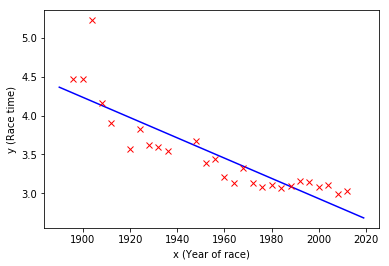

In [81]:
plot_fit(x_test, predict(x_test, w0, w1), x, y)

Does more than 10 iterations considerably improve fit in this case?

### 4. Linear algebra solution

In lectures, we saw that it's possible to solve for the optimal weights $\mathbf{w}^\star$ analytically. The solution is
$$\mathbf{w}^* = \left[\mathbf{X}^\top \mathbf{X}\right]^{-1} \mathbf{X}^\top \mathbf{y}$$
where
$$\mathbf{X} = \begin{pmatrix} 
        1 & x_1 \\ 1 & x_2 \\ \vdots & \vdots \\ 1 & x_n 
    \end{pmatrix} 
  \quad \text{and} \quad 
  \mathbf{y} = \begin{pmatrix} 
          y_1 \\ y_2 \\ \vdots \\ y_n
      \end{pmatrix}
$$

We construct $\mathbf{X}$ in the code block below, remembering to include the $x_0 = 1$ column for the bias (intercept).

In [91]:
X = np.hstack((np.ones_like(x), x))
print(X)

[[1.000e+00 1.896e+03]
 [1.000e+00 1.900e+03]
 [1.000e+00 1.904e+03]
 [1.000e+00 1.908e+03]
 [1.000e+00 1.912e+03]
 [1.000e+00 1.920e+03]
 [1.000e+00 1.924e+03]
 [1.000e+00 1.928e+03]
 [1.000e+00 1.932e+03]
 [1.000e+00 1.936e+03]
 [1.000e+00 1.948e+03]
 [1.000e+00 1.952e+03]
 [1.000e+00 1.956e+03]
 [1.000e+00 1.960e+03]
 [1.000e+00 1.964e+03]
 [1.000e+00 1.968e+03]
 [1.000e+00 1.972e+03]
 [1.000e+00 1.976e+03]
 [1.000e+00 1.980e+03]
 [1.000e+00 1.984e+03]
 [1.000e+00 1.988e+03]
 [1.000e+00 1.992e+03]
 [1.000e+00 1.996e+03]
 [1.000e+00 2.000e+03]
 [1.000e+00 2.004e+03]
 [1.000e+00 2.008e+03]
 [1.000e+00 2.012e+03]]


Although we can express $\mathbf{w}^\star$ explicitly in terms of the matrix inverse $(\mathbf{X}^\top \mathbf{X})^{-1}$, this isn't an efficient way to compute $\mathbf{w}$ numerically. It is better instead to solve the following system of linear equations:
$$\mathbf{X}^\top\mathbf{X} \mathbf{w}^\star = \mathbf{X}^\top\mathbf{y}$$

This can be done in numpy using the command

In [97]:
np.linalg.solve?

which gives

In [102]:
#w = ((X.T.dot(X))**-1).dot(X.T).dot(y)
w = np.linalg.solve(np.dot(X.T,X), np.dot(X.T, y))

print(w)

[[ 2.88952457e+01]
 [-1.29806477e-02]]


Plotting this solution, as before:

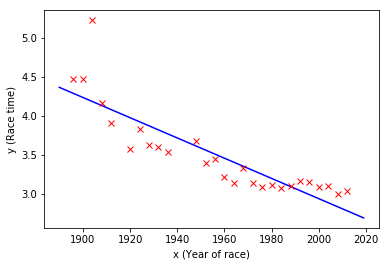

In [103]:
w0, w1 = w
plot_fit(x_test, predict(x_test, w0, w1), x, y)

You should verify that the sum of squared residuals $SSR(w_0, w_1)$, match or beats the earlier iterative result.

In [104]:
print(compute_SSR(x, y, w0, w1))

[[ 0.18689572]
 [ 0.23271424]
 [ 1.04199091]
 [ 0.02650884]
 [-0.1729305 ]
 [-0.40288939]
 [-0.0959347 ]
 [-0.24371982]
 [-0.22379154]
 [-0.22590378]
 [ 0.06115917]
 [-0.16673023]
 [-0.06867263]
 [-0.24734608]
 [-0.26849692]
 [-0.02113253]
 [-0.1615708 ]
 [-0.16652699]
 [-0.08774497]
 [-0.07611152]
 [ 0.00385547]
 [ 0.12332161]
 [ 0.1566796 ]
 [ 0.15132842]
 [ 0.22063064]
 [ 0.16867046]
 [ 0.2557473 ]]


**Note:** The error we computed above is the *training* error. It doesn't assess the model's generalization ability, it only assesses how well it's performing on the given training data. In later worksheets we'll assess the generalization ability of models using held-out evaluation data.

### 5. Solving using scikit-learn

Now that you have a good understanding of what's going on under the hood, you can use the functionality in `sklearn` to solve linear regression problems you encounter in the future. Using the `LinearRegression` module, fitting a linear regression model becomes a one-liner as shown below.

In [106]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression().fit(x, y)

The `LinearRegression` module provides access to the bias weight $w_0$ under the `intercept_` property

In [107]:
lr.intercept_

array([28.89524574])

and the non-bias weights under the `coef_` property

In [108]:
lr.coef_

array([[-0.01298065]])

You should check that these results match the solution you obtained previously. Note that sklearn also uses a numerical linear algebra solver under the hood.